In [74]:
import os, re 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

In [75]:
def get_results_dir(model_name, dataset_name, model_type, fault_type):
    d = {
        'resnet56': {
            'cifar10': {
                'full': {
                   
                    'faults_layer_p': './logs/resnet56/cifar10/int8/faults_layer_p',
                },
               
            }
        }
        
    }
    return d.get(model_name).get(dataset_name).get(model_type).get(fault_type)

def get_fault_free_accuracy(model_name, dataset_name, model_type):
    d = {'vgg16': {
        'cifar10': {
            'full': 0.9375, 
          }},
         'resnet56': {
        'cifar10': {
            'full': 0.9264, 
          }},
        }
        
    return d[model_name][dataset_name][model_type]

model_name = 'resnet56'
dataset_name = 'cifar10'

model_types = ['full']
fault_types = ['faults_layer_p']
# fault_types = ['faults_layer', 'faults_layer_masking']


In [76]:
def parse_log(log_path):
    # trial: 9, bit_position: 0, n_faults: 1, total_params: 1728, 
    # flipped_bits: 1 (1.808449e-05), changed_params: 1 (5.787037e-04), test_time: 2, test_accuracy: 0.938800
    result = {}
    with open(log_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                flipped_bits, changed_params, test_accuracy = 0, 0, None 
                items = line.split(',')
                for item in items:
                    if 'total_params' in item:
                        total_params = int(item.split()[1])
                    if 'changed_params' in item:
                        changed_params = int(item.split()[1])
                    if 'test_accuracy' in item:
                        test_accuracy = float(item.split()[1])
                    if 'trial' in item:
                        trial = int(item.split()[1])
                if test_accuracy:
                    result[trial] = [total_params, changed_params, test_accuracy]
    result = np.asarray([result[trial_id] for trial_id in sorted(result.keys())])
    return result 

def load_results(model_type, fault_type):
    results = {}
    results_dir = get_results_dir(model_name, dataset_name, model_type, fault_type)
    if not results_dir:
        return None 
    
    # ./cifar/l1-norm-pruning/logs/vgg16/cifar10/faults_layer/param-0/bit-0/nbits-1
    param_id_folders = os.listdir(results_dir)
    for param_id_folder in param_id_folders:
        param_id = int(param_id_folder.split('-')[-1])
        param_id_path = os.path.join(results_dir, param_id_folder)
        if param_id not in results:
            results[param_id] = {} 
        # get the bit folder 
        for bit_position_folder in os.listdir(param_id_path):
            bit_position = int(bit_position_folder.split('-')[-1])
            bit_position_path = os.path.join(param_id_path, bit_position_folder)
            if bit_position not in results[param_id]:
                results[param_id][bit_position] = {} 
            # get number of bits folder
            for nbits_folder in os.listdir(bit_position_path):
                nbits = float(nbits_folder[2:])
                log_path = os.path.join(bit_position_path, nbits_folder, 'logs.txt')
                if os.path.isfile(log_path):
                    results[param_id][bit_position][nbits] = parse_log(log_path)
    return results 
        
data = {} # model_type -> fault_type -> param_id -> bit_position -> n_bits 
for model_type in model_types:
    data[model_type] = {} 
    for fault_type in fault_types:
        results = load_results(model_type, fault_type)
        if results:
            data[model_type][fault_type] = results 

param_id = 0 
print(data[model_type][fault_type][param_id])


{0: {0.1: array([[4.320e+02, 4.300e+01, 6.689e-01],
       [4.320e+02, 4.300e+01, 5.182e-01],
       [4.320e+02, 4.300e+01, 5.631e-01],
       [4.320e+02, 4.300e+01, 3.984e-01],
       [4.320e+02, 4.300e+01, 6.397e-01],
       [4.320e+02, 4.300e+01, 4.111e-01],
       [4.320e+02, 4.300e+01, 5.803e-01],
       [4.320e+02, 4.300e+01, 8.193e-01],
       [4.320e+02, 4.300e+01, 6.805e-01],
       [4.320e+02, 4.300e+01, 4.897e-01]]), 0.01: array([[432.    ,   4.    ,   0.9264],
       [432.    ,   4.    ,   0.9123],
       [432.    ,   4.    ,   0.8916],
       [432.    ,   4.    ,   0.9264],
       [432.    ,   4.    ,   0.9067],
       [432.    ,   4.    ,   0.9013],
       [432.    ,   4.    ,   0.8915],
       [432.    ,   4.    ,   0.8955],
       [432.    ,   4.    ,   0.9076],
       [432.    ,   4.    ,   0.8985]])}, 1: {0.1: array([[432.    ,  43.    ,   0.8901],
       [432.    ,  43.    ,   0.8428],
       [432.    ,  43.    ,   0.8877],
       [432.    ,  43.    ,   0.846 ],
    

prec1: 0.9264
[1, -24, -8, -20, -55, -21, -4, 2, -3, -8, -14, -14, -7, -19, -8, -10, -2, -19, 23, 38, 9, 35, 48, 29, 22, 42, 7, -12, -16, -1, -10, 41, 5, 8, 15, -10, -45, -26, -5, -40, 55, 26, -30, 8, -7, -12, 7, -1, -8, 67]


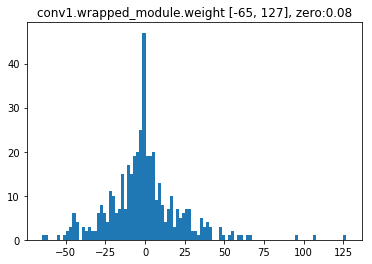

[16, -9, 2, 12, 14, -9, 6, -7, -17, 0, 1, -16, -17, -46, 14, 10, 52, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 13, 0, 15, 3, -12, 13, 5, 4, -2, 38, -7, 20, -72, 10, 11, 36, 8, 21, 23, 3, -17, -28]


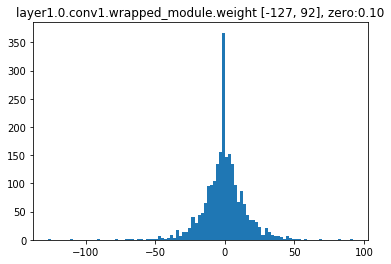

[-4, -21, -9, -25, 84, 3, -7, -32, -5, -3, -16, -15, 3, -3, -5, 18, 18, 5, 1, -14, -9, -7, 0, -6, 21, 13, -3, -6, 57, 24, 2, 39, 30, -4, -2, 0, -35, -3, 10, -30, -16, 3, -10, 2, -5, -28, -26, -2, -15, 42]


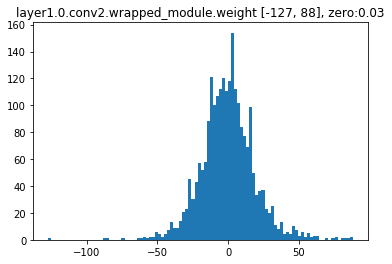

[-44, -61, -66, -33, -18, -22, 20, 42, 27, -70, -57, -48, 14, 10, -23, 45, 49, 17, 17, -1, -5, 16, -2, -22, 26, 11, -2, 15, 17, 11, 12, 26, 29, -45, -31, -17, 28, 39, 23, 14, 24, -7, -63, -59, -63, -53, -69, -59, -9, -33]


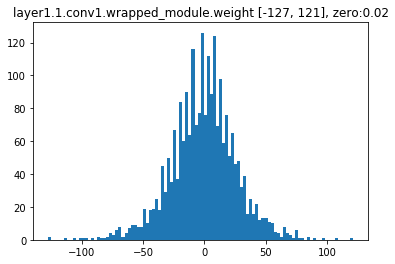

[-45, -29, -36, 37, 48, 55, 27, 46, 3, 46, 46, 9, -25, -43, -46, -28, -32, -43, -52, -43, -19, -20, -9, 1, 19, 79, 40, -28, -4, 7, -19, -25, -25, -2, -3, -37, 65, 40, -4, -42, 1, -46, -51, -82, -62, 4, 26, -16, 11, 80]


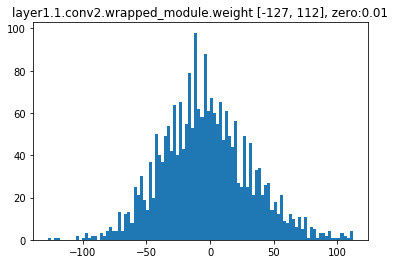

[3, -11, 15, -14, -26, -19, -35, -27, -6, 11, -8, 8, -15, -24, 9, -18, -23, -14, -15, 12, 13, -13, 8, 14, -5, -7, -8, 27, 20, 10, 5, 14, 9, 8, 19, 18, 4, 9, -3, 3, 7, 13, 1, -5, -10, -22, -45, -44, -16, -22]


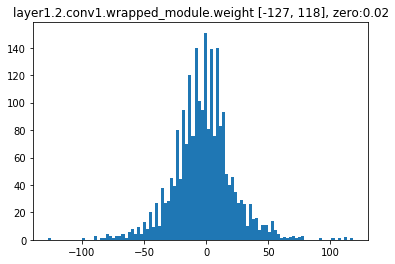

[-10, 6, 10, -28, -32, 3, 5, -3, -1, -11, 9, -13, 8, -1, 2, 3, -1, 14, -8, -8, -14, 27, 25, 26, -16, -8, -16, 12, 7, -8, -24, -39, -12, 8, 23, 5, 6, 12, -4, 17, 6, 7, 25, 32, 18, -2, -24, -14, -6, -6]


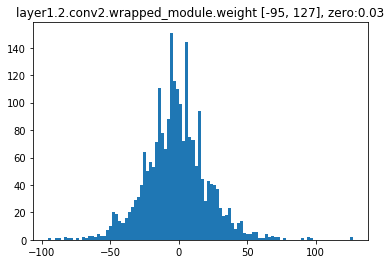

[-10, -5, 4, 0, -7, -6, -3, 4, -8, 19, 7, -2, 4, 19, 16, 0, -3, 6, -17, -16, -7, -10, -18, -12, -7, -17, -2, -7, -12, -7, 2, 8, 6, 9, 21, 15, -13, -27, -15, -24, -10, -13, -22, -16, -2, -2, -12, -8, 29, 12]


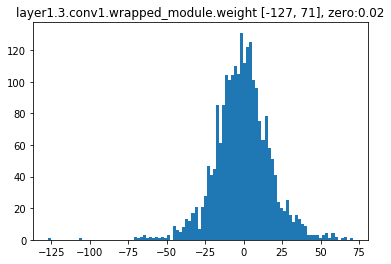

[-29, -7, -56, -4, -12, -11, 7, 29, -2, 59, 67, -19, -80, -85, -24, 78, 84, 59, 31, 2, -10, -6, 27, 18, 81, 32, -1, 6, -26, 19, -46, 39, -22, 10, -61, -10, -13, -20, -13, 31, 76, 11, -26, -43, -1, -4, -14, -30, -19, -28]


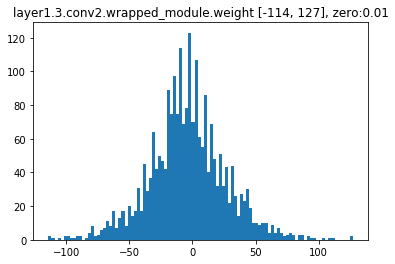

[-24, -13, 6, -28, 2, 15, -9, -12, -19, -32, -14, 19, -34, -9, 22, -36, 12, 19, -23, -17, 0, -40, -2, -17, -33, 2, -21, 5, -1, -8, 44, 6, -10, 64, 11, -5, 4, 14, 13, -8, 2, 18, -9, 7, -1, -19, -16, -31, -2, -11]


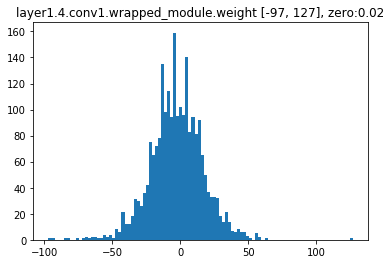

[17, 16, 18, -6, 28, 14, -20, 3, 18, 1, -26, -4, -39, 20, -23, 1, -37, -26, -10, -20, -16, -8, -3, -15, 5, -11, 8, 0, 11, 46, 4, 6, -24, -13, -29, -19, 20, -1, -15, 3, 21, 39, 14, -27, -70, 28, -16, -29, 5, -24]


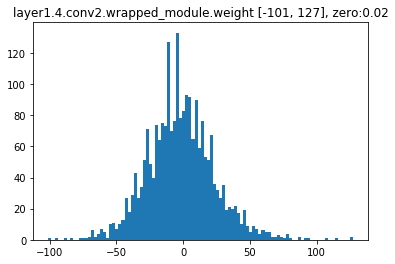

[5, -49, -27, -44, 20, 26, -4, -30, -66, 49, -17, -71, 72, -34, -62, 5, 4, -23, -17, -24, -14, 11, -34, -15, -2, -5, 12, -48, -17, 41, -8, -14, 50, 14, 9, 31, 3, -20, -70, 82, 4, -59, 29, 8, -22, -10, -26, -9, -33, -60]


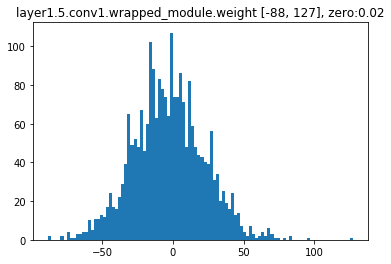

[-4, -13, 43, 39, 25, -63, -12, 28, 72, -45, -50, -25, -10, 14, -9, 48, -18, -17, -28, -50, -29, 5, -12, 11, 16, 6, 33, 10, 42, 10, -33, -41, -51, 38, 58, 35, -57, -5, -53, -39, 7, -20, 3, 1, -43, 28, 4, 32, 19, 8]


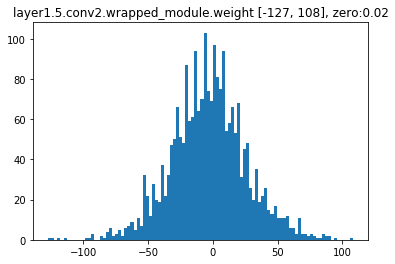

[17, -1, 30, 32, 28, -18, 52, 32, -24, 9, -29, 1, -6, -10, 27, 30, 9, 5, 0, 10, 24, 0, 1, 32, 3, 2, -4, 18, -12, -3, 27, -4, 0, 0, -6, 7, -14, 7, -53, -31, -2, -7, -28, -19, 23, -3, -34, -4, -48, -12]


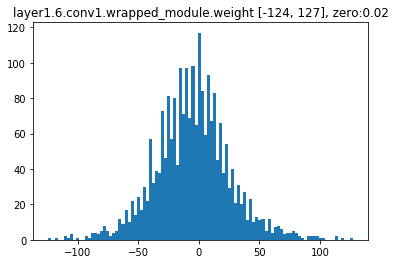

[0, -6, -25, -9, -61, -30, -7, -57, -35, 2, -19, 13, 5, 30, 29, 39, 5, 47, -44, 3, 44, -53, -27, -14, 37, 70, 88, 12, -46, -26, -7, 12, 10, -2, -50, 31, -5, -9, 4, 6, -15, -61, -11, 10, 13, -15, 20, 39, -9, 5]


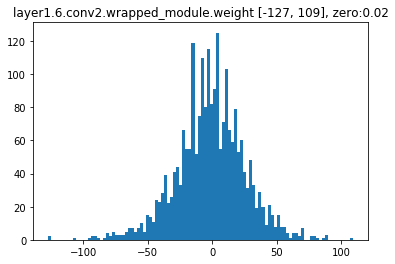

[-15, -18, -56, 11, -26, 4, -12, 2, -32, 61, 16, -48, 87, 7, -76, 86, -22, -65, -83, -59, -15, -42, -51, -52, -99, -61, -61, 31, -3, -23, 20, -20, 30, 30, 14, 45, -58, -28, 40, -29, 48, 23, -61, 43, 7, 0, -24, -30, 28, -46]


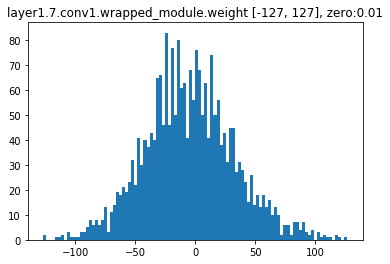

[-33, 3, 8, -20, -6, -10, 3, 23, 46, 15, 15, 6, 19, 22, 9, 9, -14, -38, -6, 12, -25, -6, 1, 0, -1, 0, -18, -10, 13, -1, -18, -32, -42, 48, 32, 18, -43, -56, -47, -5, -14, -20, 13, 0, -19, 23, 30, -22, 8, 3]


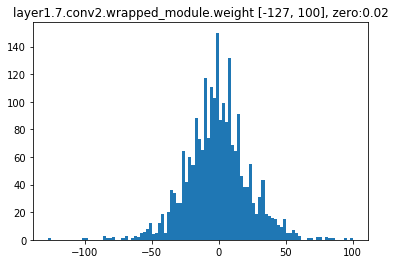

[-1, -47, -53, 70, -9, 7, -1, -51, -2, -12, -23, -6, 28, -8, -21, 80, -12, -32, -2, -36, 32, -3, -61, -22, 38, -52, -43, 0, 61, -33, -22, 55, 3, -49, 42, 8, -6, -13, 53, -10, -21, 20, -7, -41, -19, -34, -6, -6, 4, -2]


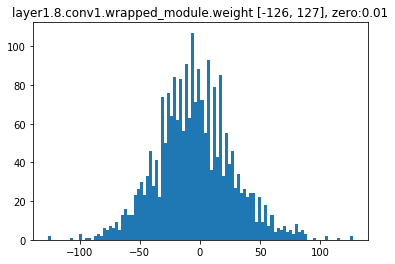

[10, 15, 13, 39, 20, 37, 23, -7, -28, -9, -10, 7, 18, 31, 9, -3, -5, -11, -11, -30, 8, 28, 8, -9, -44, -29, 8, -3, -30, -18, 2, -4, 39, -2, -25, -4, -3, -26, 20, 31, 12, 28, -43, -8, -10, 27, -26, 14, 37, 16]


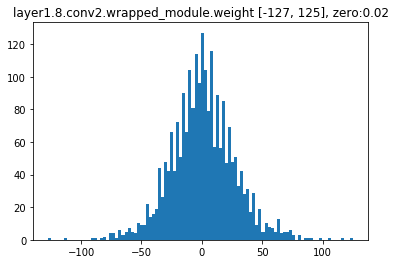

[-8, -34, -28, -32, -39, -23, -16, -7, 20, -17, -34, -6, -14, -19, 4, -29, 1, 14, -11, 13, 37, 6, 46, 22, 46, 44, -16, -28, -24, 1, -42, -41, -6, -25, -28, 5, -33, -26, -6, -42, -25, -11, -8, -11, -4, -54, -85, -40, -59, -67]


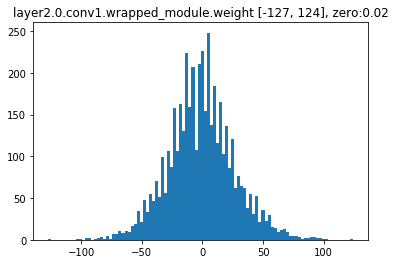

[16, 2, -22, -27, -36, -30, -20, -47, -33, 14, -12, -4, -29, -36, -13, 1, -7, -17, -15, -21, -8, 16, 34, 28, 27, 26, 15, 8, 24, 17, 0, 29, 19, -11, 17, 5, 18, -16, 23, -47, -127, -56, -22, -90, -20, -17, -41, -52, 0, 21]


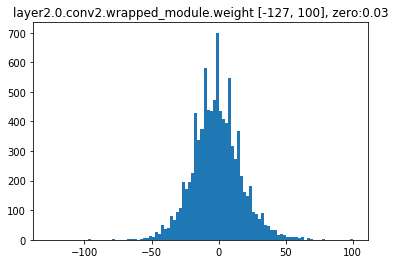

[28, -2, -10, 5, -1, -2, 21, 10, 6, 49, 17, -33, 34, -30, -49, 33, -6, -27, 18, -8, -7, 49, -18, -3, 9, -26, 1, -7, -11, -6, 39, 4, -29, 17, -30, -17, 0, 4, 22, 25, -5, -4, 12, -34, -3, 1, 30, 15, 10, -30]


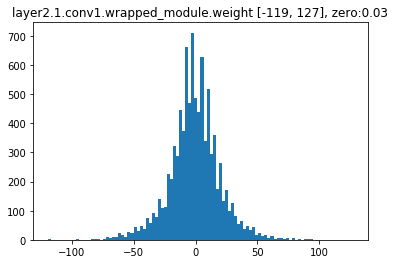

[-7, 9, 5, 10, 30, 25, -1, 1, 15, 5, -10, 7, -3, -16, -9, 11, -23, -40, 23, 2, -7, 7, -8, -36, 20, 15, -10, -32, -11, 12, -4, -4, -7, 33, 43, 13, -8, -17, -5, -22, -30, -7, 28, 24, 8, 2, -15, -34, 4, 1]


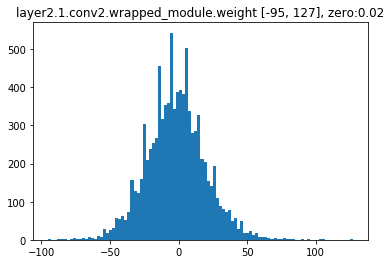

[-34, 3, -2, 21, 15, -18, 58, 56, -17, -33, -47, -14, -26, -18, -53, 42, 90, -8, -19, 5, 48, 13, -15, 57, 8, 10, 0, -13, -10, -4, 28, 18, -1, 48, 47, 9, 39, 9, 3, 11, -2, 22, -43, -1, -8, -14, 0, -30, -32, -28]


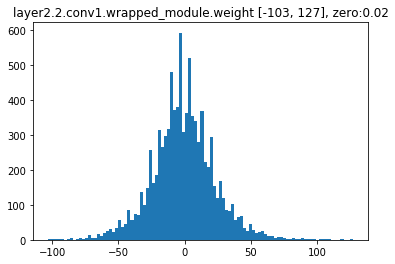

[-1, 1, -9, -2, 12, 8, -3, 8, 8, -9, -2, 20, -4, -12, -2, 10, -9, 4, -7, -12, -2, 1, -1, 7, 4, -5, 8, -4, 7, 11, -5, 1, 3, 6, -9, -8, -5, -9, 4, 4, 3, -7, 17, 6, 11, -10, -43, 18, 1, -35]


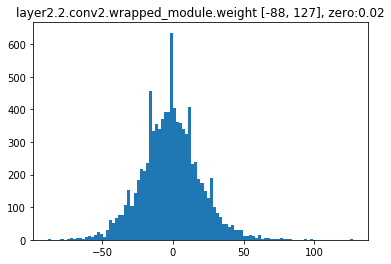

[-20, 9, 5, -9, -26, -2, 10, -26, -7, 45, -8, -4, 42, -29, -13, 30, -39, -25, -31, -25, 14, -11, -5, 22, -9, -7, 22, 0, 19, -5, 6, 19, -13, -14, 20, -8, 1, -25, 11, 14, -7, 13, -15, 28, 4, -18, -28, 13, 2, -14]


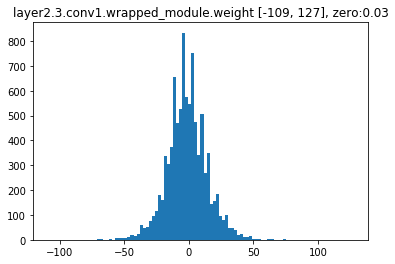

[-28, 21, -32, -14, 37, -23, 1, 45, -25, -4, 6, 19, -7, 8, 42, -12, 1, 15, 3, -2, 2, -5, -9, 8, 9, 19, 25, -24, -21, -16, 6, 25, 33, -7, 14, 2, 8, 10, 4, -10, -15, -10, -22, -20, -5, 7, -2, 2, 1, -8]


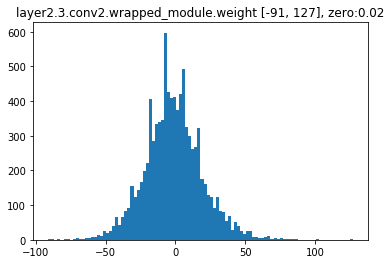

[-26, 7, -12, -20, 45, -25, -41, -21, -3, 10, 9, 17, -17, -26, -7, 0, 18, -4, 19, 1, -39, -11, 42, 69, -31, -47, 14, 4, 14, 2, 11, 42, 14, -17, -28, 9, -29, -12, -36, 38, 68, 48, -60, -41, -25, -7, -18, 30, 12, -25]


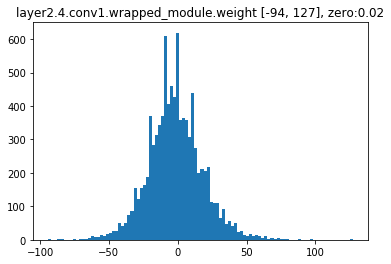

[0, -30, -33, -6, -29, -21, 3, -1, 4, 17, 1, -1, -26, -20, -11, 48, 64, 56, -33, 40, -17, -24, 48, -6, 1, 51, -9, -3, -14, -33, -3, -12, -18, -1, -8, -11, 4, 8, 9, 0, -3, -4, 15, 14, 16, -9, -17, -32, 13, -1]


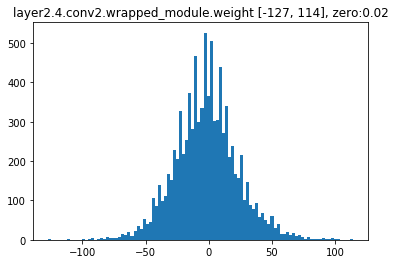

[-54, -54, -41, 3, 2, 9, -22, -22, -41, -46, -26, -11, -23, -2, 0, 16, 15, -7, 23, 54, 32, 17, 31, -3, 48, 36, 13, -14, -25, -16, -4, 23, 51, -25, 4, -1, -11, 19, 6, -47, -48, -63, -9, -10, 1, -18, -16, -4, -1, 3]


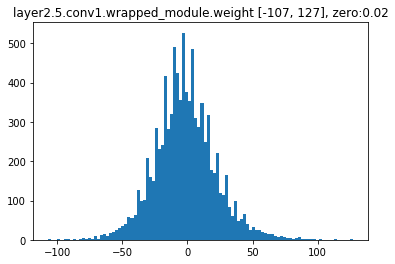

[1, 3, -4, -8, -3, -10, -5, 4, 3, -9, 4, 13, -9, -8, 4, -12, -18, -4, 4, 7, 4, 2, -7, -2, 2, -1, 4, 8, 2, -10, 5, 7, 2, -4, 1, 5, 6, 6, 3, -1, -6, -2, 2, -9, -5, -14, -1, 8, -19, -4]


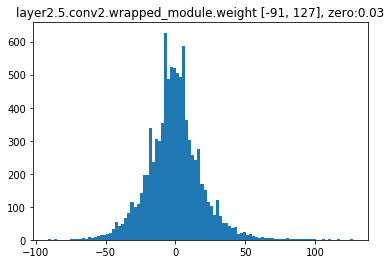

[-4, 1, -36, 8, 21, -20, 32, 8, -34, -11, -17, 25, -46, -21, -6, 30, 47, 6, -28, -15, 19, -15, 44, 31, 21, 29, -21, 17, -5, -36, -5, -44, -28, -32, 6, 72, -2, 11, 8, -9, 16, 42, -3, 14, 25, 1, 75, 54, -6, -19]


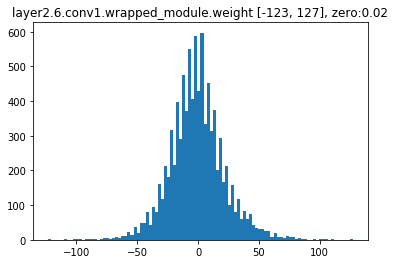

[-20, -24, -30, -7, 11, 28, -4, 7, 15, 24, 5, -27, -35, -31, -70, -6, 0, -41, 22, -1, -8, 1, -19, -26, 1, -17, -34, 14, -6, -23, 30, 17, -10, 28, 25, 0, -23, -12, -17, -24, -14, -2, 8, 25, 28, -36, -23, -34, 52, 55]


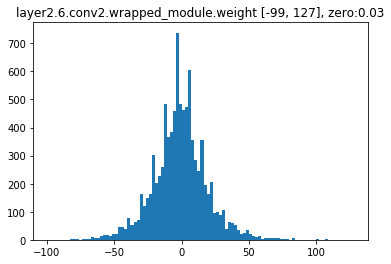

[-6, -20, -57, 28, 19, -32, -19, -30, -30, 7, -27, 48, -10, 9, 33, 8, -4, 5, -69, -28, 9, -26, 70, 61, 37, 11, -52, 28, -11, -48, 20, 5, 8, 4, 8, 11, -21, -71, -23, -26, 8, 46, -36, 24, 4, 9, -16, 10, -16, -58]


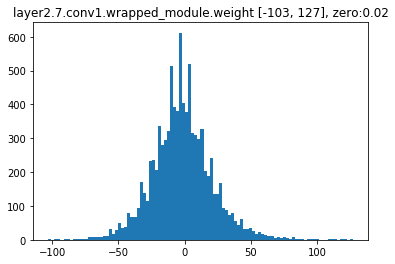

[-8, -10, 1, -7, -6, -7, -11, -5, -1, 10, 4, 2, 12, 2, 3, 8, 6, 10, 13, 0, -7, 2, 2, -6, 6, 8, 0, 0, 1, -6, 4, 3, -9, 13, 13, 1, 8, 10, 5, 6, 7, 2, 0, 2, 0, 4, 1, 8, -3, -6]


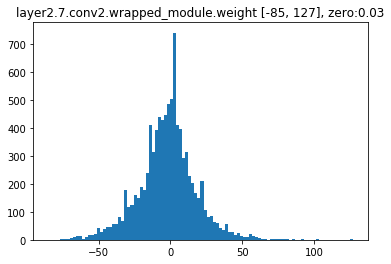

[-43, -31, 4, 40, 43, 22, -14, -34, -35, 17, 9, -8, -10, -3, 1, 44, -1, 3, -33, -48, -25, -14, -2, 19, 15, 22, -14, 24, 16, -23, 38, 31, 11, 13, -5, -1, 3, -17, 2, -39, -33, -6, 25, 37, 10, -6, -3, -4, -36, -33]


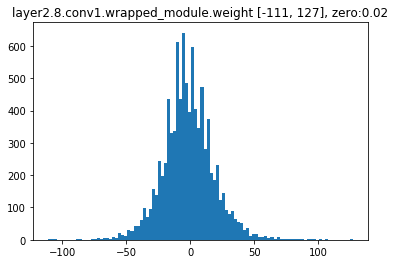

[3, 0, -8, 8, -7, -12, -11, -11, -4, 16, 8, 6, 19, 32, 22, 32, 53, 47, 23, 13, 10, 15, 12, 8, 26, 20, 8, 10, 4, -2, 3, -3, -6, 1, 2, -3, 32, 22, 2, 16, 12, -12, 6, 11, 7, 22, 6, -19, -2, -14]


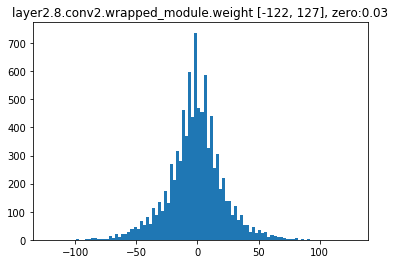

[-19, -10, 18, -21, 1, 27, 0, 13, 20, 1, -14, -4, -15, -4, 22, -18, -9, 30, 24, 18, -21, 38, 40, -21, 27, 23, -2, -12, 19, 10, -1, 27, 19, -14, 33, 10, 4, -7, -9, 32, -4, -9, 40, -7, -6, 10, -4, -5, 28, -2]


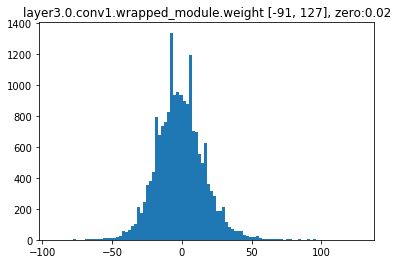

[-8, -12, 13, -12, -34, 15, -24, -21, -12, 0, -1, -4, -6, -1, -24, 2, -2, -12, 3, 48, 12, -6, -1, 1, 4, -15, 1, 6, -12, -44, -7, 21, 1, -14, -27, -37, -19, -42, -23, -3, 6, 17, -15, -4, -13, 14, 2, -20, -15, -10]


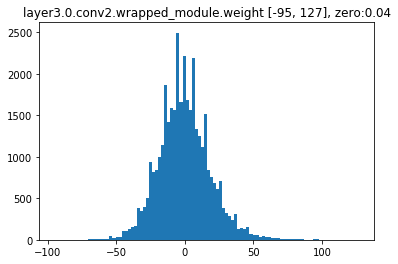

[-1, -11, -43, 3, -16, -4, 4, -30, -22, -6, 15, 17, 1, 7, -2, -24, 10, 9, -24, -26, 9, -12, -29, 33, -5, -31, 2, 10, -22, -18, 26, -6, -32, 36, 7, -20, 1, 9, -21, 12, 42, 1, 7, 31, 12, 25, -10, -9, -1, -4]


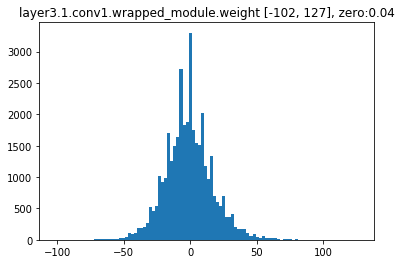

[-49, -23, -10, 4, 1, 6, -5, -5, -7, 39, 18, -2, 37, 7, -5, -1, -22, 5, 2, 15, 19, -22, 12, 18, 9, 20, 19, -6, 20, 23, -63, -42, -4, -10, 2, -40, 4, 32, 31, -26, 27, 56, -13, 17, 35, 49, -16, -52, -2, -38]


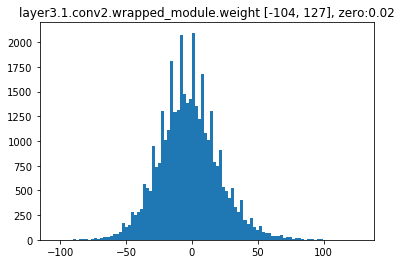

[14, 40, 12, 3, -2, -15, 39, 26, 19, 11, 14, -12, -7, 16, 11, -10, -4, 7, 4, 18, 3, -1, -11, 18, -8, -17, 20, 0, 23, -21, 22, 33, -12, 13, 34, -15, 17, 42, 14, 35, 42, 1, 36, 27, 1, 19, 31, 23, 21, 24]


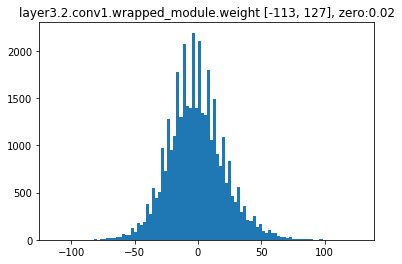

[25, 21, -6, 19, 26, -10, 22, 30, -15, 9, -27, -21, 30, 13, 14, -8, 5, -3, 20, 2, 1, 10, -2, -8, 41, 39, 24, -21, -39, -23, -7, -22, 1, -6, -3, -2, -49, 19, 4, -53, -18, -15, -22, 0, 14, -9, 1, -23, 12, 4]


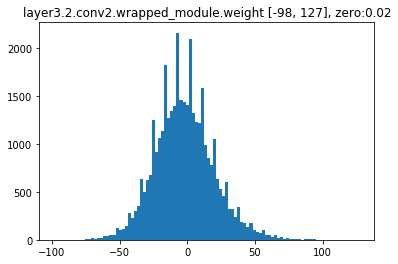

[15, 1, 10, 14, -7, 26, 30, -3, -4, -23, -12, -22, -8, -13, 0, 2, 19, -22, 3, -16, -24, 0, 4, -20, 27, -4, -25, 26, 16, 3, -10, 5, 6, 23, 30, 5, 6, 13, -25, 1, 16, 6, 33, 21, 40, 61, 17, -5, 20, -6]


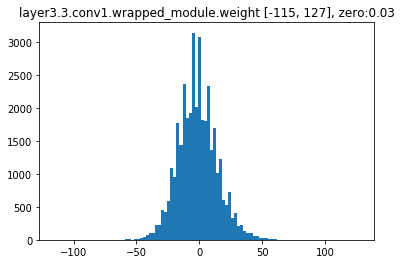

[-5, 22, 11, 1, 3, 17, -6, -13, 9, 20, 15, 15, 19, 11, 5, 1, -2, -15, 13, 14, 11, -30, 14, 35, -39, -5, 29, -2, 5, -1, -11, -34, -10, 1, -1, 3, 11, 27, 15, 12, -9, 13, 15, 9, 6, -22, -33, -17, -12, 0]


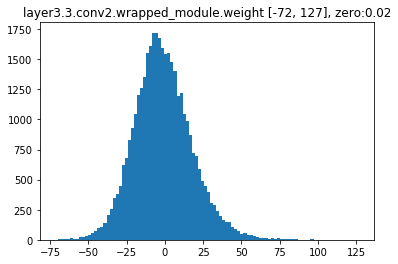

[9, 8, -2, 2, 4, 10, -10, -16, -24, -14, -16, -27, 16, 27, -6, 10, -1, 2, -16, -22, 23, 3, 2, 37, 7, 5, 11, 8, 24, 5, 9, 1, 4, -13, -12, -3, -3, 17, 16, -22, -16, -12, -12, -7, -24, -3, 13, 23, 15, 15]


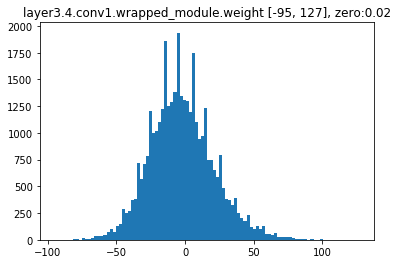

[-14, -17, -30, 32, 24, 9, 25, -2, -12, 30, 11, 36, 33, 16, 17, 12, -3, 1, 15, 3, -4, 24, 18, -1, 12, 5, -12, -4, -8, -14, 38, 24, -2, 57, 35, -7, -8, -17, -11, -6, -3, -3, -23, -4, 10, -10, -15, -24, 3, 16]


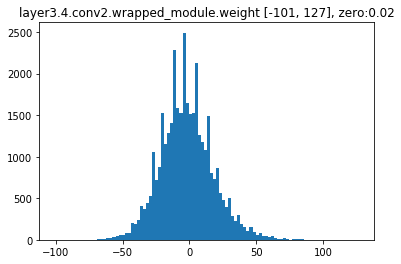

[48, 10, 3, -43, -55, 4, -87, -58, 3, -18, 15, 27, -24, 9, 38, 68, 4, 20, -1, 7, 6, -31, -12, -8, -17, 11, 4, -12, 0, 13, 6, 11, 2, -5, 4, 14, 7, 63, 46, -31, 8, 27, -6, -21, -15, -22, -38, -55, -35, -68]


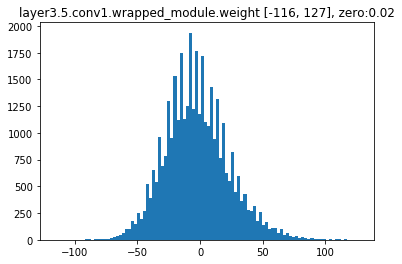

[-17, 19, 3, -22, -10, -3, 1, -13, 20, -9, -28, -35, -7, -5, -1, 9, 1, 5, -10, -26, -29, -17, -18, -7, -3, 9, -1, -32, 15, 15, 6, 0, -13, -7, -21, -26, 1, -1, 1, -10, -4, 17, -16, -10, 6, -21, -5, 35, -16, -6]


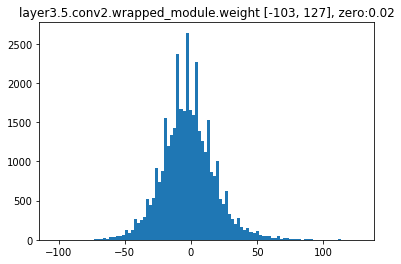

[-18, 2, -15, -10, -17, -38, 13, -31, -43, 0, 9, -9, -28, -40, -36, 16, 18, -5, 31, 28, 2, -10, -16, -17, -21, -17, 17, -10, -2, -24, -33, -33, -29, -36, -44, -32, -25, -35, -20, -19, -21, -6, 5, 14, 34, -12, 32, 48, 31, 46]


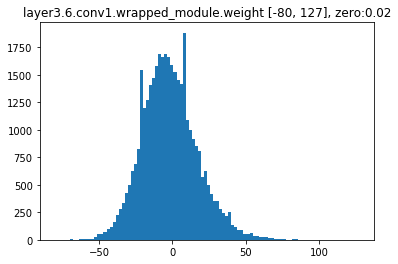

[14, 2, -4, 4, -7, -10, 25, 28, 17, 16, 20, 24, 19, 12, 8, 18, 14, 14, -10, -23, -31, -7, -8, -10, 1, 6, 7, 17, 4, 7, 12, 8, 3, -18, -9, -5, 6, 0, -18, 10, 10, -8, -27, -17, -16, -6, -5, 6, -4, 15]


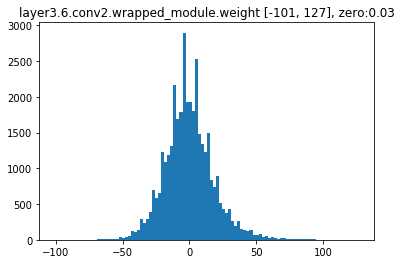

[-11, -8, -7, 10, 3, 2, 16, 10, -3, 6, 0, -5, -14, -6, -6, -9, -8, -5, 5, -3, -10, -18, -17, -22, 5, 4, -5, 0, 8, 14, 15, 8, 14, 15, -2, 7, 1, 2, -2, -14, -12, -14, -23, -28, -28, 11, 11, 12, 28, 31]


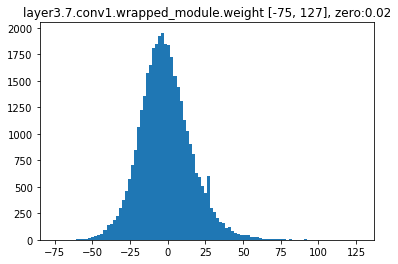

[3, 6, 8, 17, 17, 21, 10, -1, 4, -4, -4, 2, -18, -17, -12, -21, -25, -23, 27, 26, 25, 22, 22, 24, 13, 4, 14, -8, -10, -15, -21, -21, -21, -17, -9, -10, 22, 13, 21, 16, 6, 11, -8, -23, -20, -8, -5, -3, -10, -11]


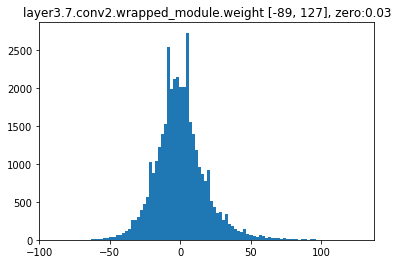

[0, -3, -3, 3, -1, -3, 4, 1, -1, -10, -6, -6, -2, -2, -3, 3, 1, -1, -1, 3, 9, -2, 3, 6, -4, 3, 3, -2, 1, 6, 1, 0, 1, 1, -1, -4, 0, 0, -1, 0, 1, -1, -6, -3, -9, -4, -2, 0, -3, -1]


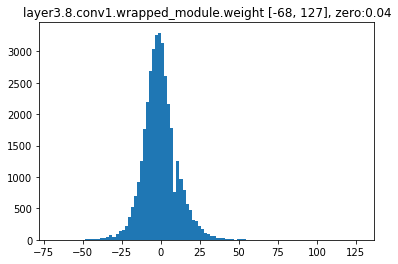

[-22, -22, -21, -6, -7, -4, 2, 1, 0, 9, 1, 3, 8, 3, 6, 18, 12, 9, -5, -1, 2, -15, -13, -8, -17, -11, -8, -2, -5, 0, 3, 6, 2, 27, 29, 12, 17, 15, 7, -3, -4, -4, -5, -4, -5, -12, -13, -4, -13, -12]


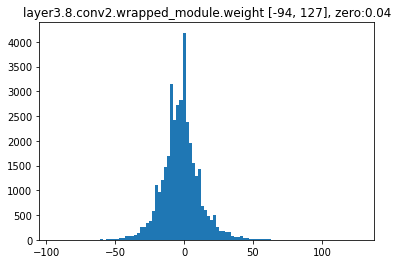

[16, 77, -16, 16, -51, 31, -3, -59, 87, -48, -28, 73, -7, -36, -7, -42, 0, -4, 0, -35, 22, -8, -31, -22, 2, -27, -11, 41, 22, -36, 36, 10, -66, -9, -18, -13, -13, 21, 69, -13, -15, -18, -50, 75, 54, -57, 55, -62, 35, -52]


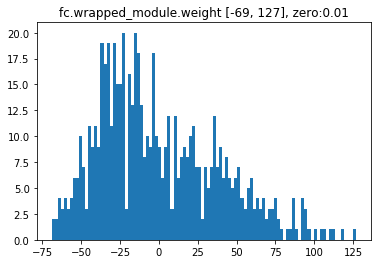

In [77]:
import torch 

model_path = './logs/'+ model_name +'/' + dataset_name +'/int8/quantized.pth.tar'
checkpoint = torch.load(model_path)
prec1 = checkpoint['prec1']
print('prec1:', prec1)
state_dict = checkpoint['state_dict']
param_id_to_name = {}
param_id_to_shape = {} 
param_id = 0 
weights_id = []

for key in state_dict:
    tensor = state_dict[key]
    if len(tensor.size()) >= 2:
        weights_id.append(param_id)
        param_id_to_shape[param_id] = tuple(tensor.size())
        
    if 'weight' in key or 'bias' in key:
        param_id_to_name[param_id] = key
        param_id += 1
    if len(tensor.size()) < 2:
        continue
    minv, maxv = tensor.min().item(), tensor.max().item() 
    tensor = tensor.cpu().numpy().ravel()
    print([int(x) for x in tensor[:50]])
    plt.hist(tensor, bins=100)
#     plt.plot(tensor.cpu().numpy().ravel())
    zeros = sum([x==0 for x in tensor])
    plt.title(key+' [%d, %d], zero:%.2f' %(minv, maxv, zeros/len(tensor)))
    plt.show()

In [78]:
print(len(weights_id))
for weight_id in weights_id:
    print(weight_id, param_id_to_name[weight_id], param_id_to_shape[weight_id])

56
0 conv1.wrapped_module.weight (16, 3, 3, 3)
3 layer1.0.conv1.wrapped_module.weight (16, 16, 3, 3)
6 layer1.0.conv2.wrapped_module.weight (16, 16, 3, 3)
9 layer1.1.conv1.wrapped_module.weight (16, 16, 3, 3)
12 layer1.1.conv2.wrapped_module.weight (16, 16, 3, 3)
15 layer1.2.conv1.wrapped_module.weight (16, 16, 3, 3)
18 layer1.2.conv2.wrapped_module.weight (16, 16, 3, 3)
21 layer1.3.conv1.wrapped_module.weight (16, 16, 3, 3)
24 layer1.3.conv2.wrapped_module.weight (16, 16, 3, 3)
27 layer1.4.conv1.wrapped_module.weight (16, 16, 3, 3)
30 layer1.4.conv2.wrapped_module.weight (16, 16, 3, 3)
33 layer1.5.conv1.wrapped_module.weight (16, 16, 3, 3)
36 layer1.5.conv2.wrapped_module.weight (16, 16, 3, 3)
39 layer1.6.conv1.wrapped_module.weight (16, 16, 3, 3)
42 layer1.6.conv2.wrapped_module.weight (16, 16, 3, 3)
45 layer1.7.conv1.wrapped_module.weight (16, 16, 3, 3)
48 layer1.7.conv2.wrapped_module.weight (16, 16, 3, 3)
51 layer1.8.conv1.wrapped_module.weight (16, 16, 3, 3)
54 layer1.8.conv2.wra

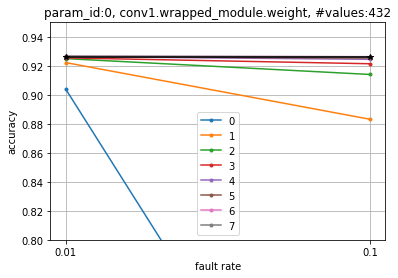

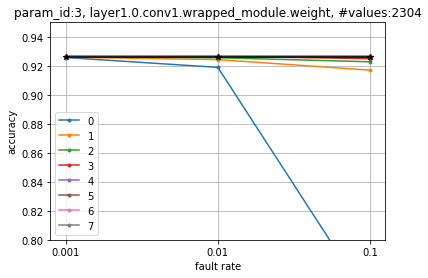

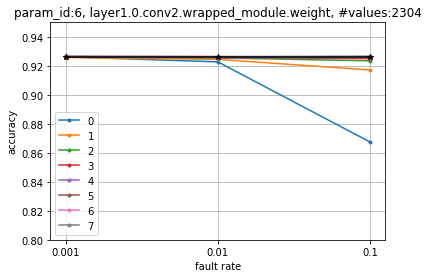

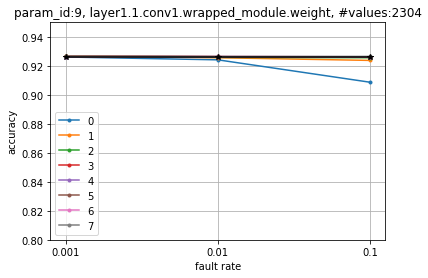

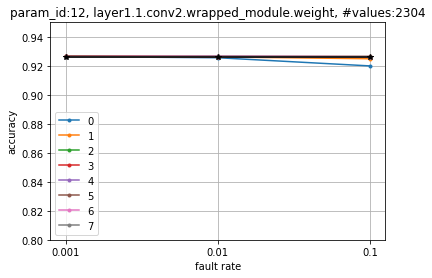

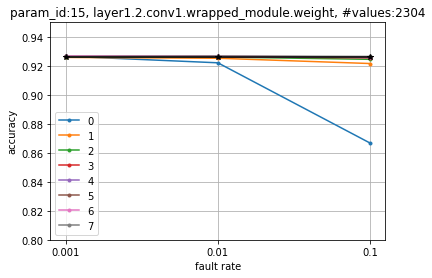

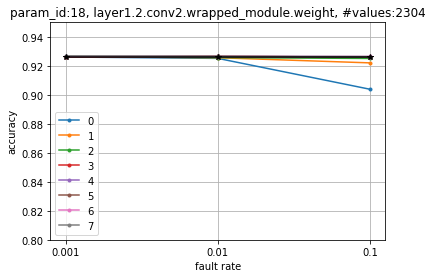

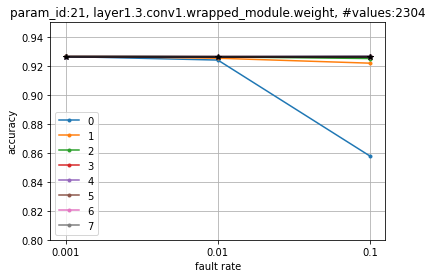

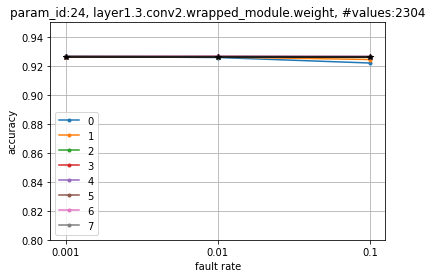

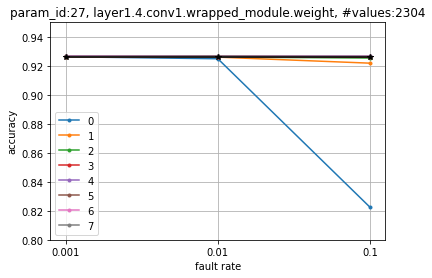

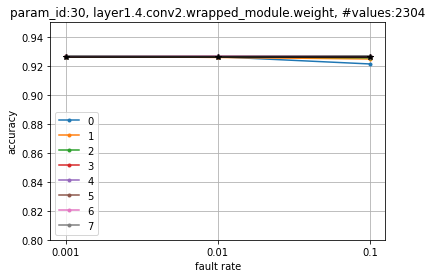

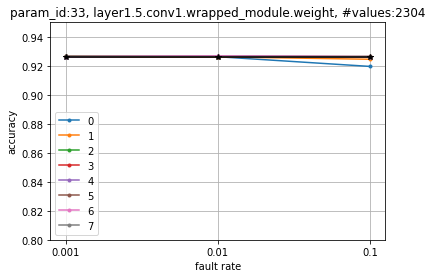

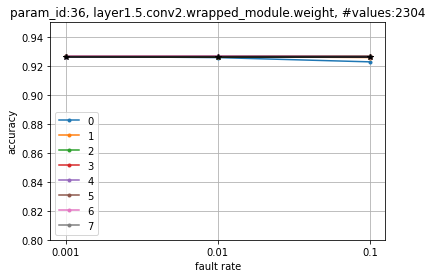

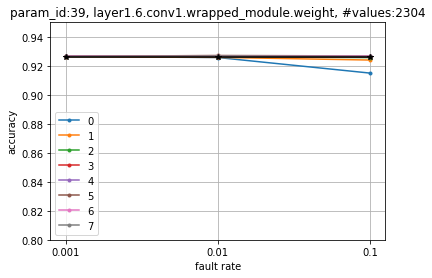

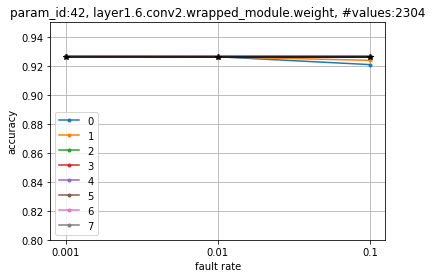

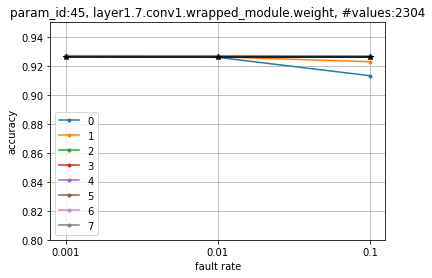

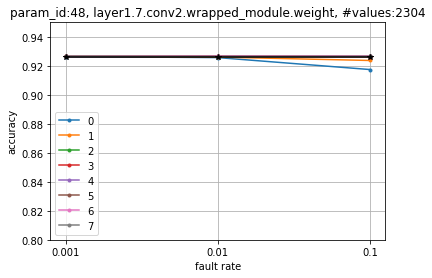

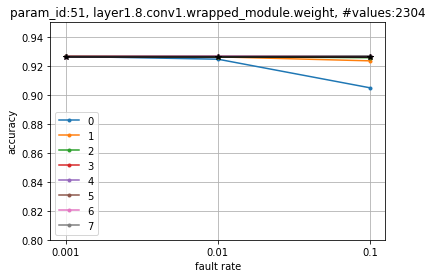

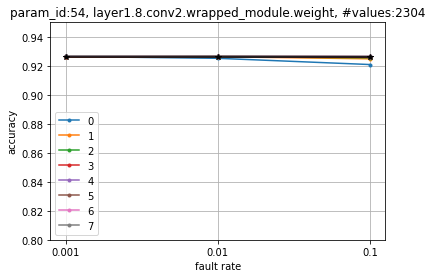

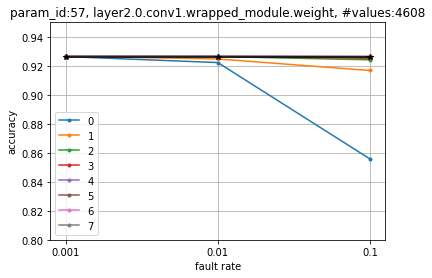

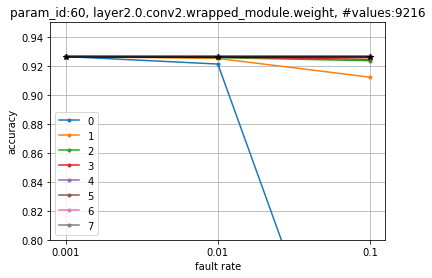

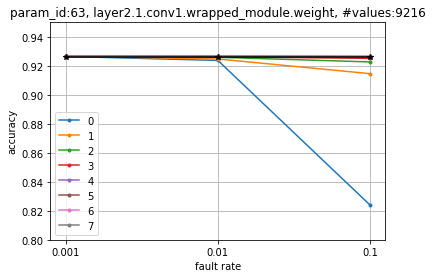

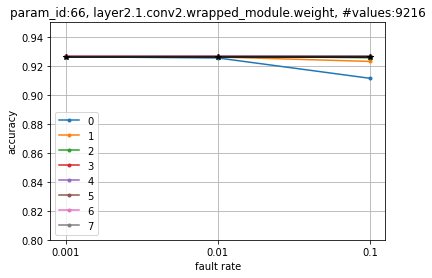

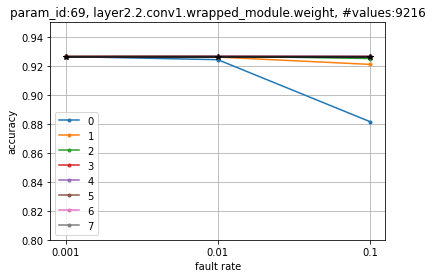

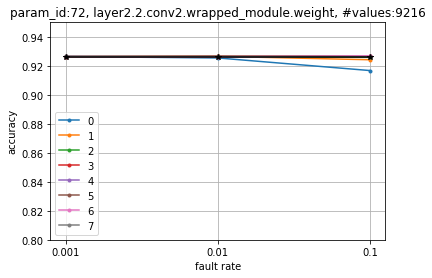

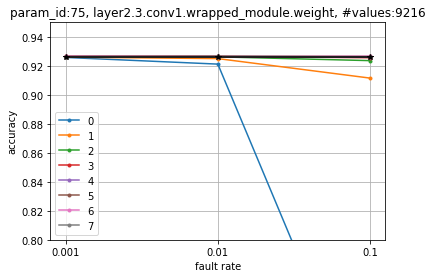

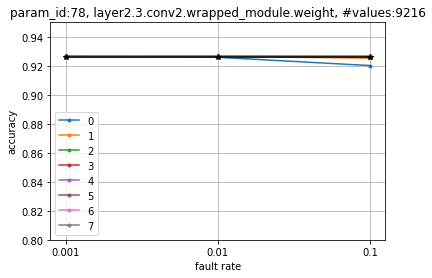

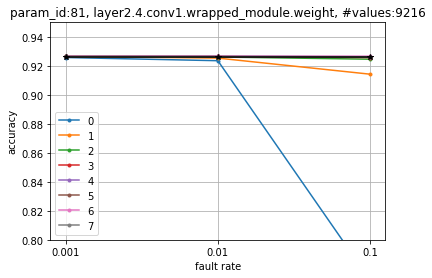

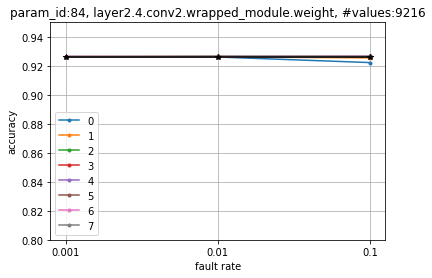

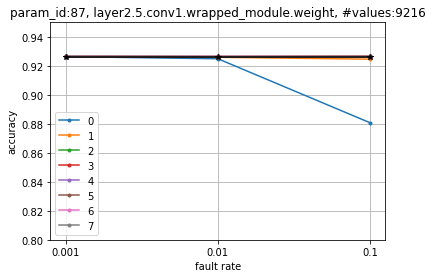

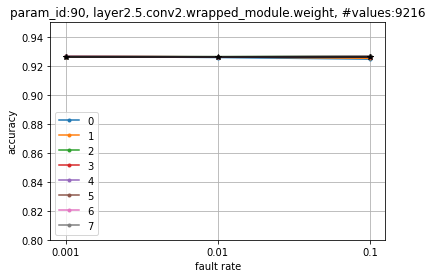

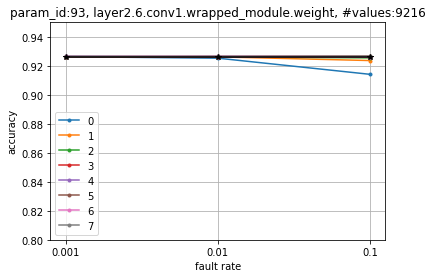

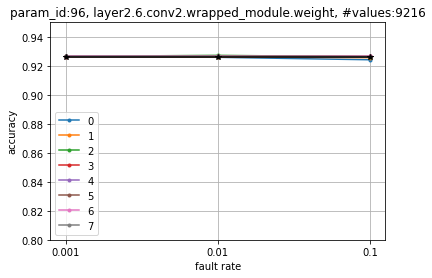

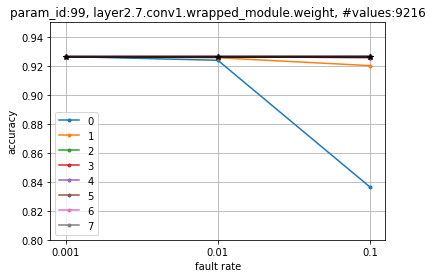

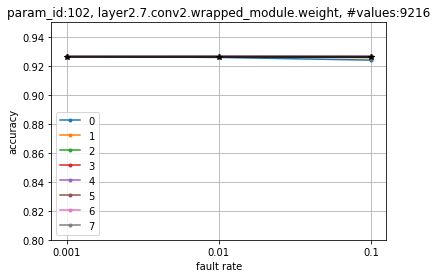

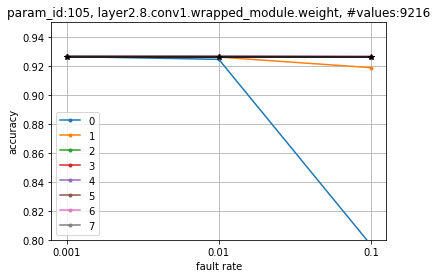

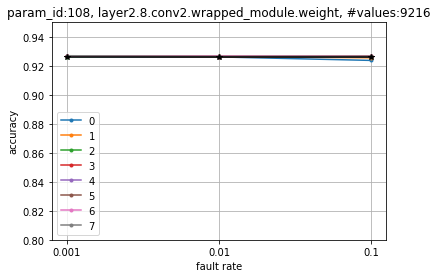

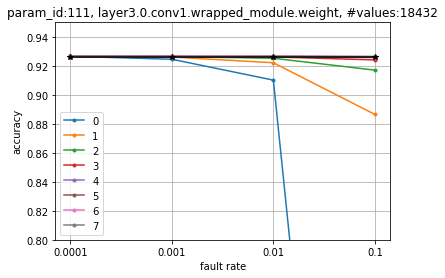

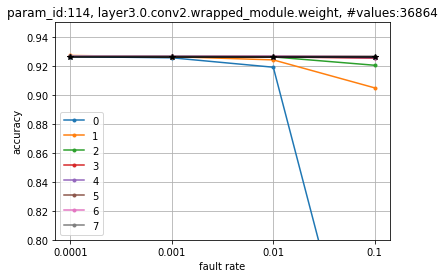

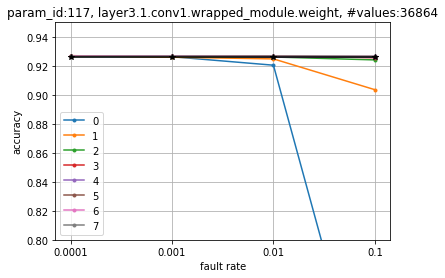

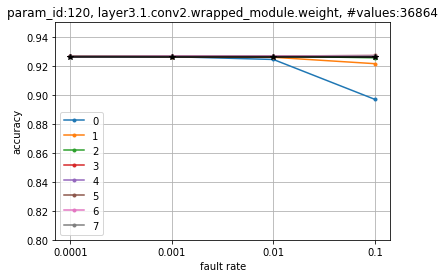

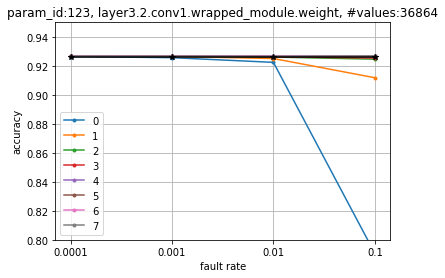

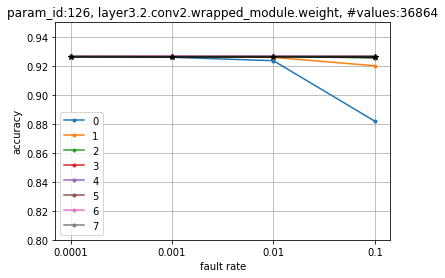

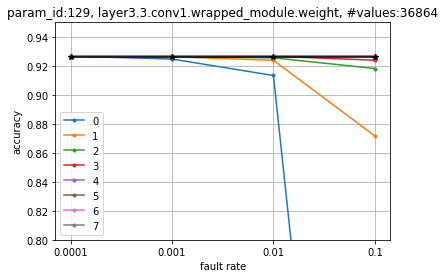

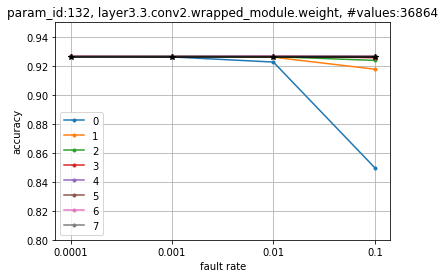

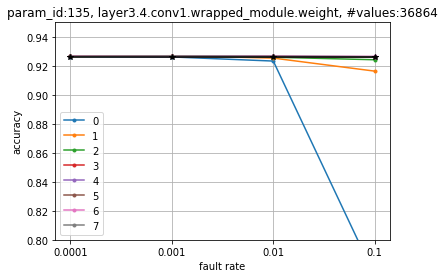

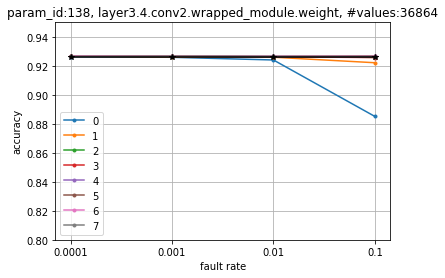

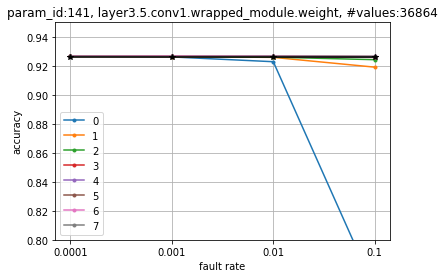

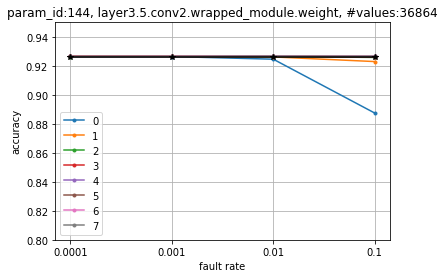

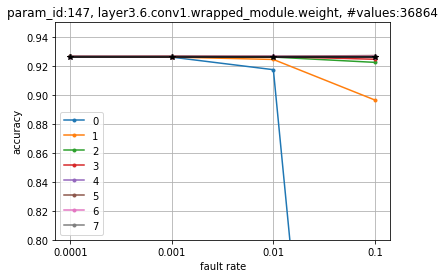

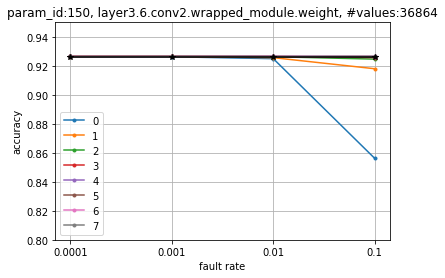

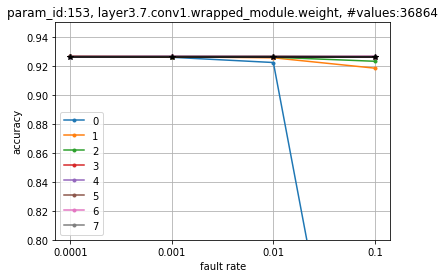

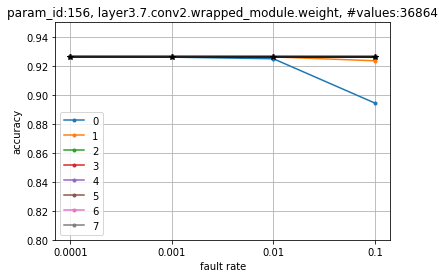

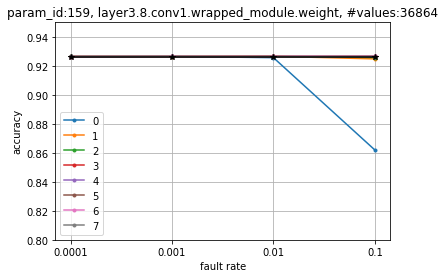

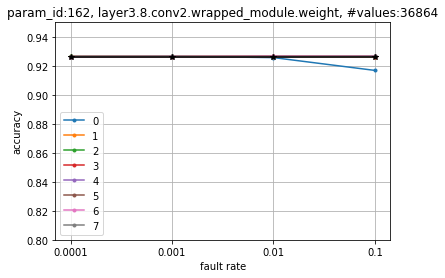

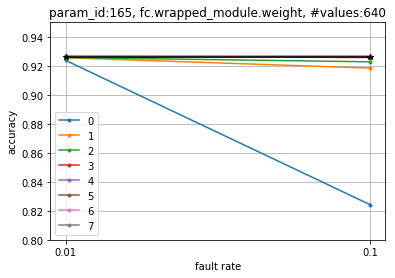

In [79]:
# compare same param_id, same bit_position, x: n_bits, y: accuracy 
for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:

        for param_id in sorted(data[model_type][fault_type].keys()):
            bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:10]
            
            for bit_position in bit_positions:
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
               
                num_values = res[fault_rates[0]][0, 0]
                accuracies = [np.median(res[fault_rate], axis=0)[2] for fault_rate in fault_rates]
                x = np.log10(fault_rates)
                plt.plot(x, accuracies, label=str(bit_position), marker='.')
            plt.legend()    
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
            plt.grid()
            plt.ylabel('accuracy')
            plt.xlabel('fault rate')
            plt.title('param_id:%d, %s, #values:%d' 
                      %(param_id, param_id_to_name[param_id], res[fault_rates[0]][0, 0]))
            plt.xticks(x, [s for i, s in enumerate(map(str, fault_rates))])
            plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k')
            plt.ylim(0.8, 0.95)
            plt.show()
                
                

In [80]:
# # compare same param_id, same n_bits, x: bit_position, y: accuracy 
# for model_type in model_types:
#     fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
#     for fault_type in fault_types:
#         for param_id in sorted(data[model_type][fault_type].keys()):
#             bit_positions = sorted(data[model_type][fault_type][param_id].keys())[:12]
#             n_bits_list = sorted(data[model_type][fault_type][param_id][0].keys())
            
#             for n_bits in n_bits_list:   
#                 res = data[model_type][fault_type][param_id]
#                 num_values = res[bit_positions[0]][n_bits][0, 0]
#                 # x: bit_positions
#                 x, accuracies = [], [] 
#                 for bp in bit_positions:
#                     if bp in res:
#                         accuracies.append(np.min(res[bp][n_bits], axis=0)[2])
#                         x.append(bp)
#                 plt.plot(x, accuracies, marker='.', 
#                          label=str((n_bits, round(n_bits*1.0/num_values, 6))))
                
#             plt.legend()    
# #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
#             plt.grid()
#             plt.ylabel('accuracy')
#             plt.xlabel('bit position')
#             plt.title('param_id:%d, %s, #values:%d' %(param_id, param_id_to_name[param_id], res[0][1][0, 0])) # 0: bit position; 1: n_bits 
#             plt.xticks(range(len(bit_positions)), map(str, [x if x%2 else '' for x in bit_positions ]))
#             plt.plot(fault_free_accuracy, marker='*', color='r')
#             plt.show()
                

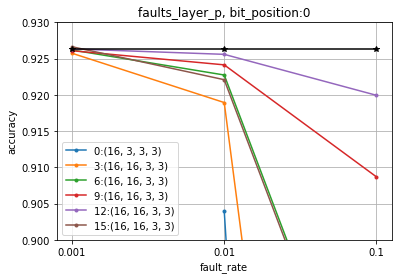

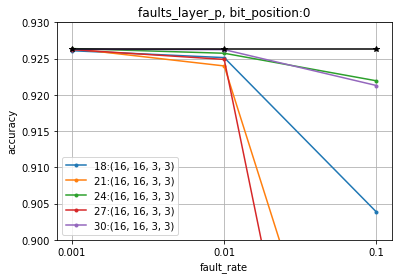

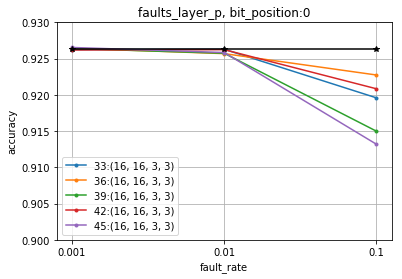

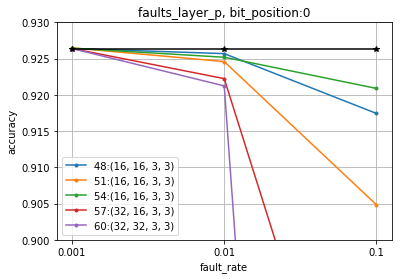

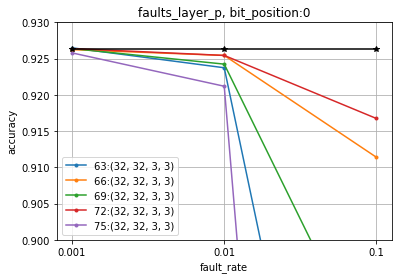

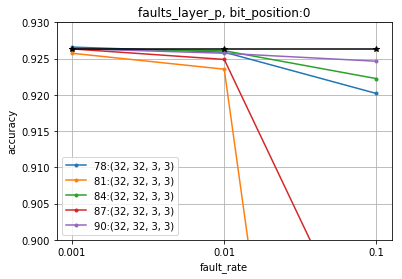

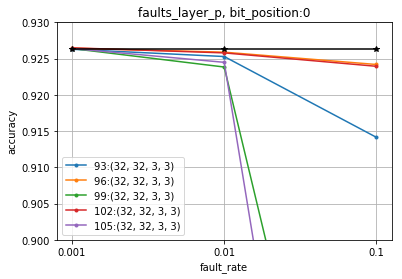

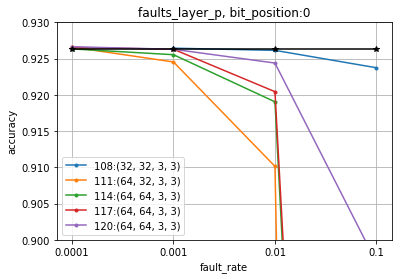

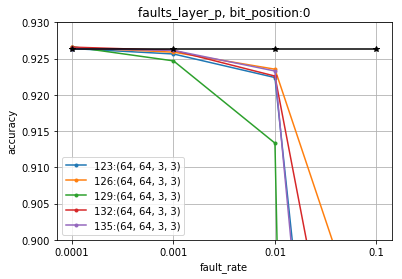

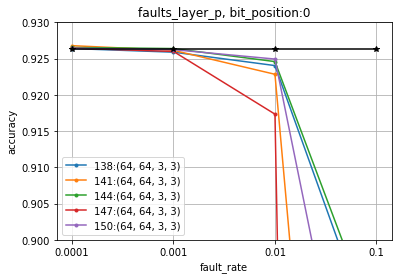

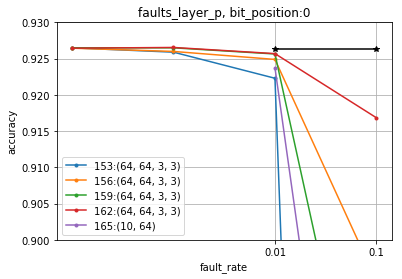

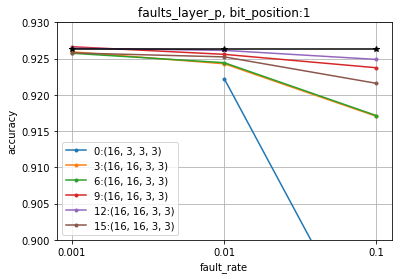

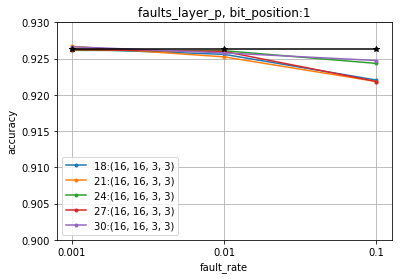

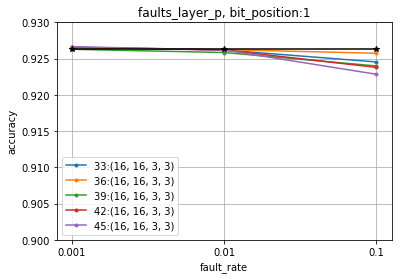

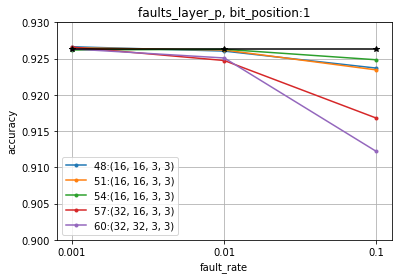

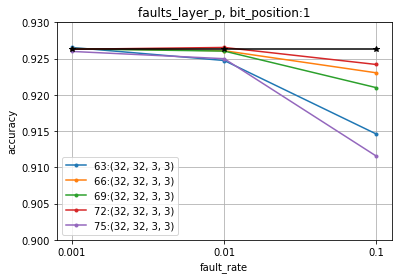

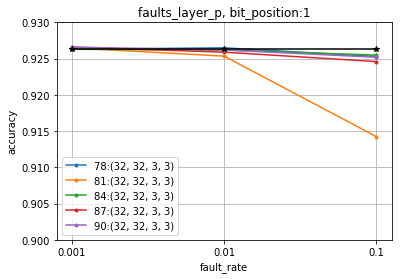

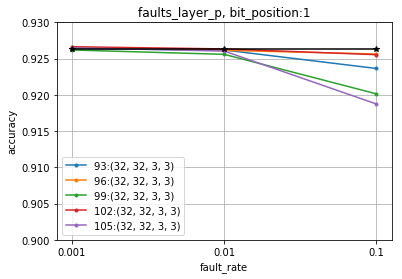

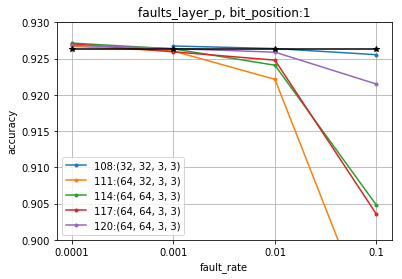

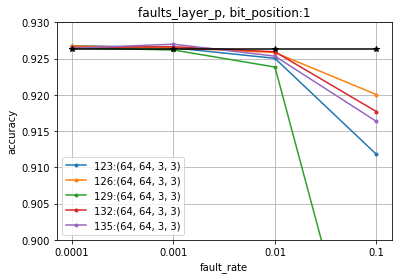

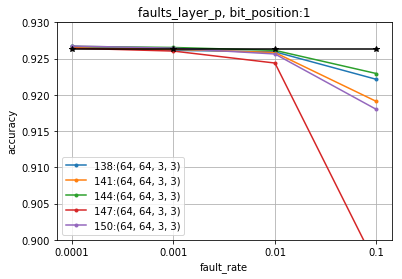

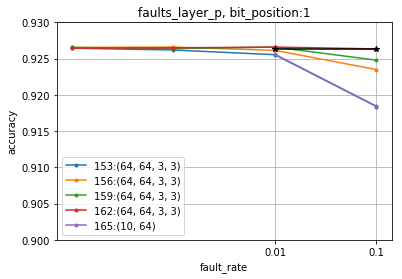

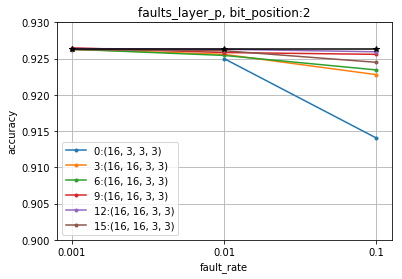

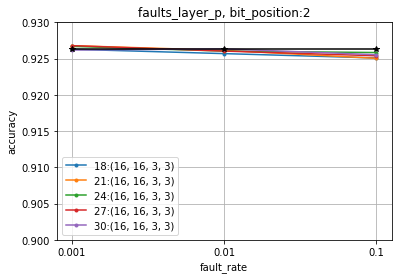

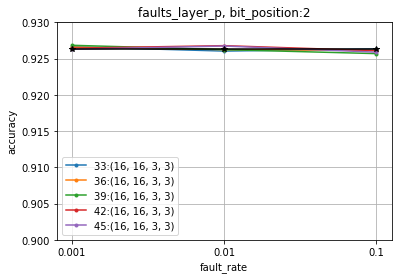

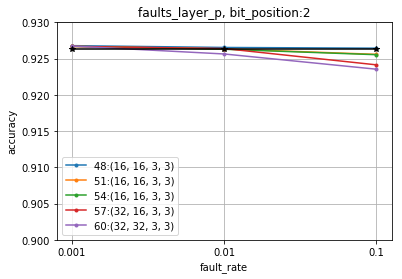

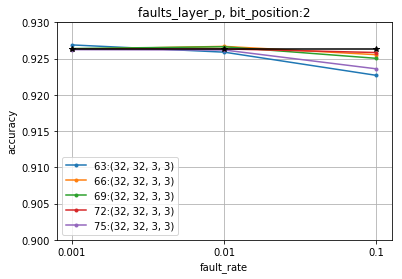

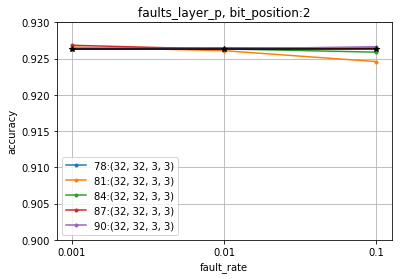

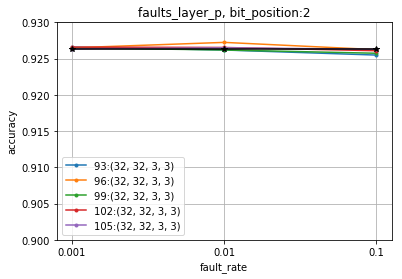

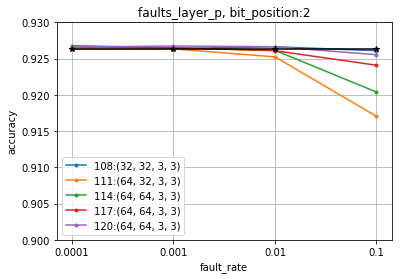

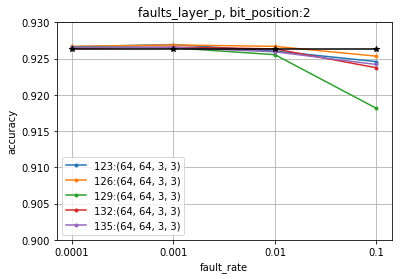

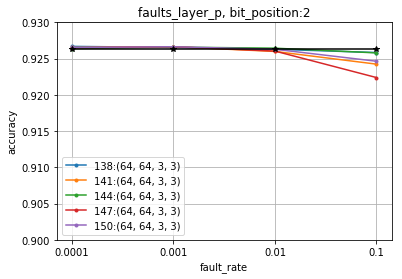

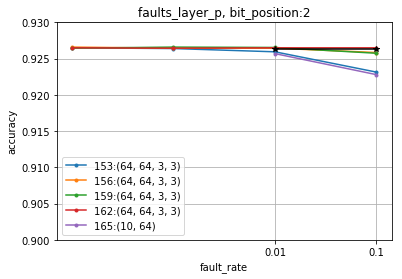

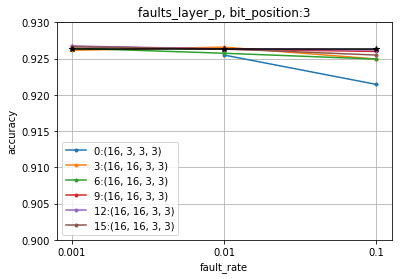

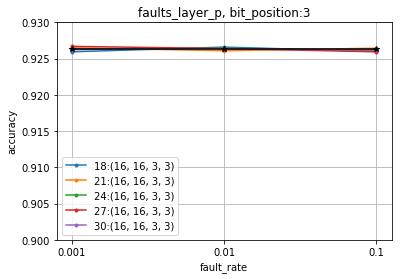

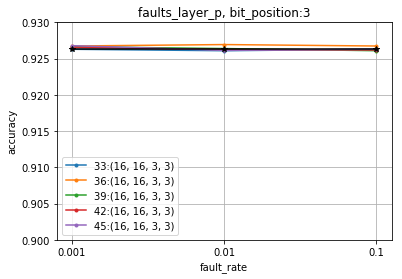

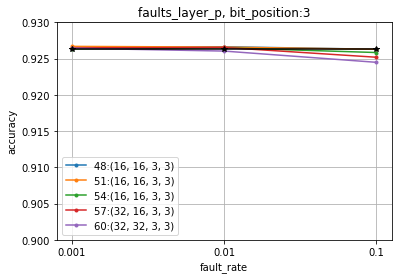

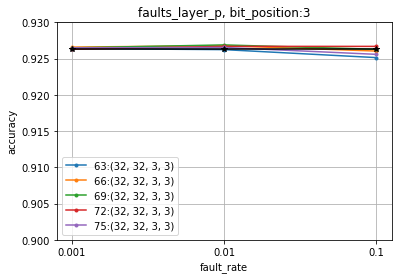

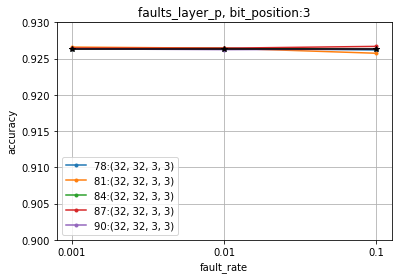

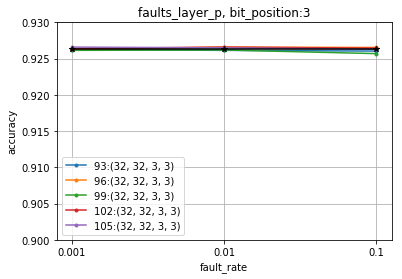

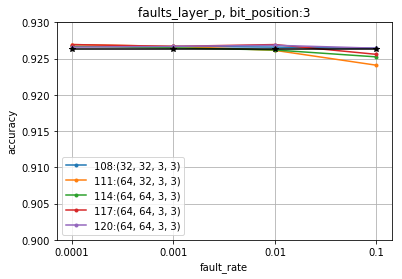

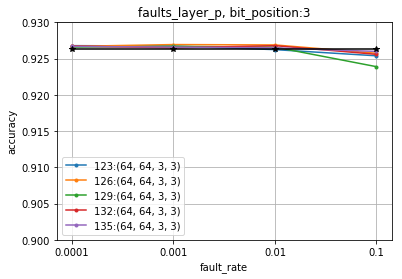

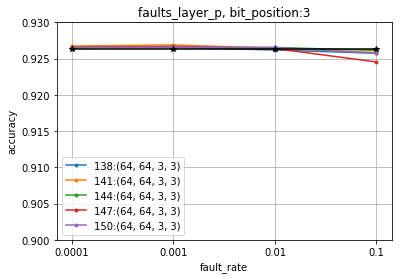

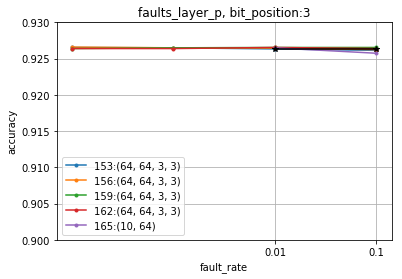

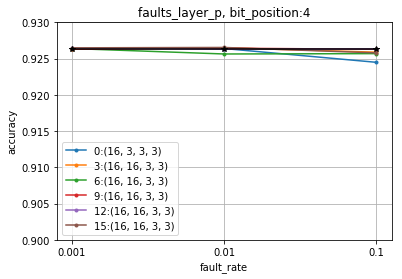

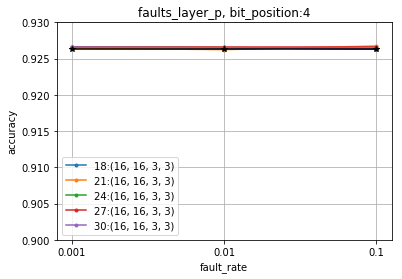

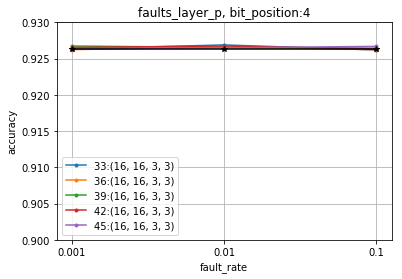

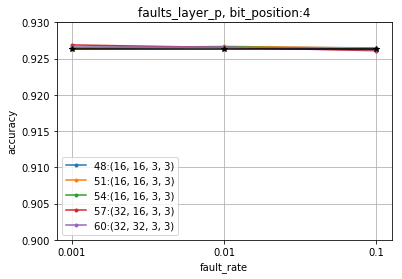

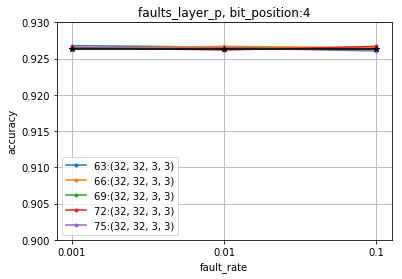

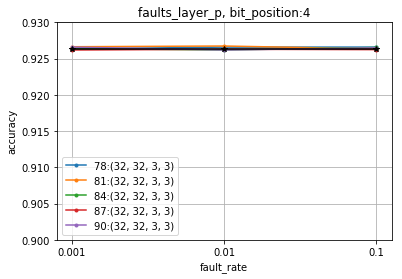

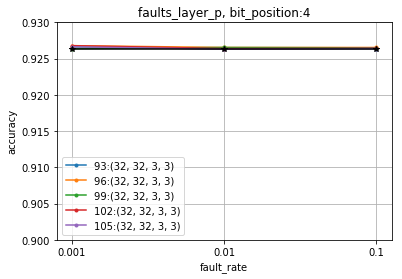

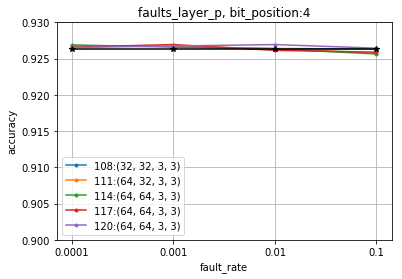

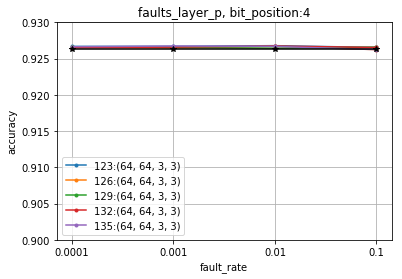

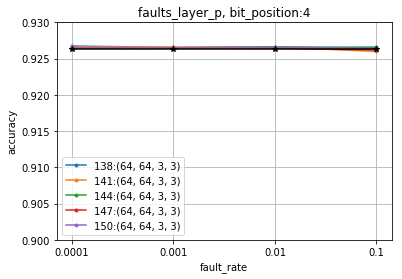

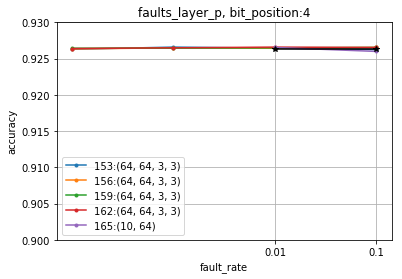

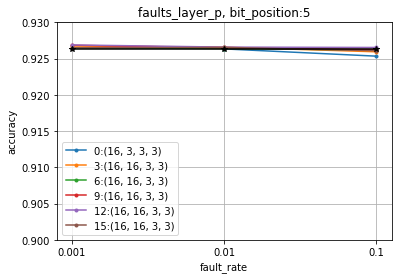

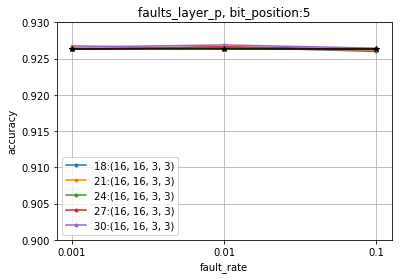

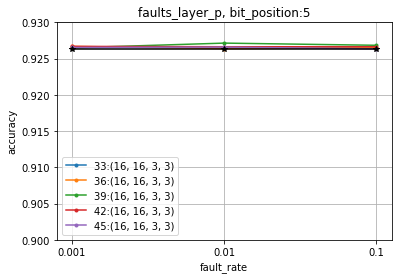

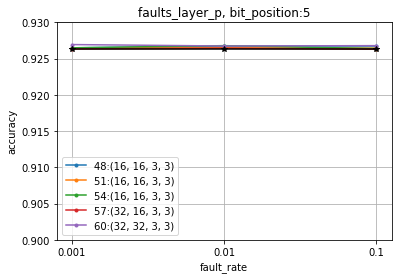

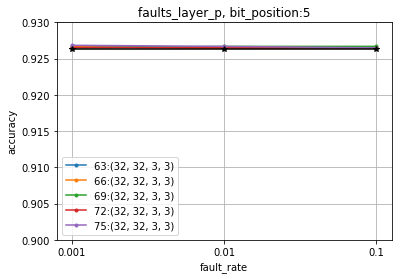

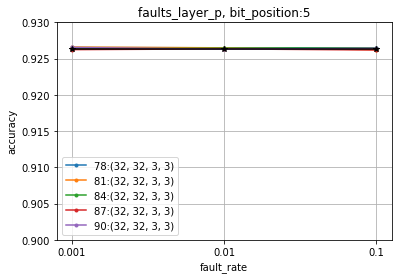

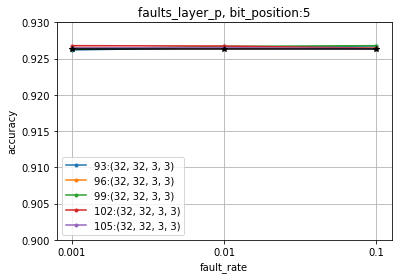

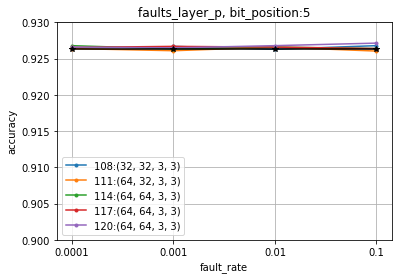

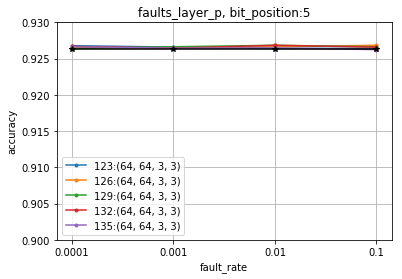

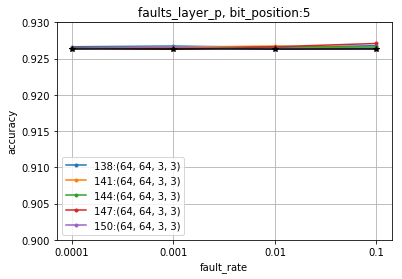

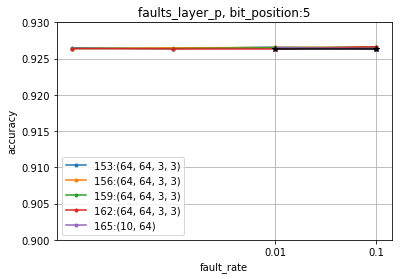

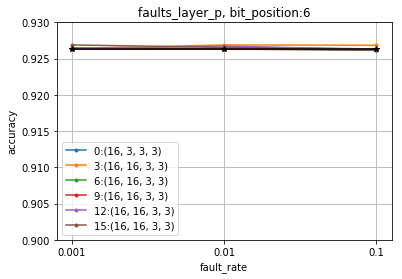

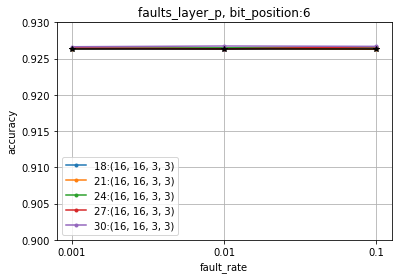

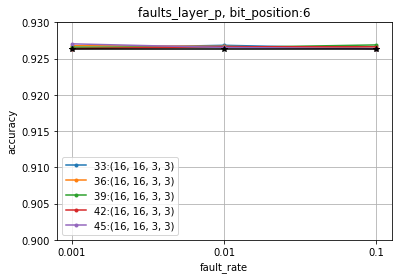

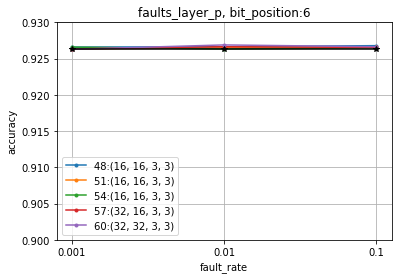

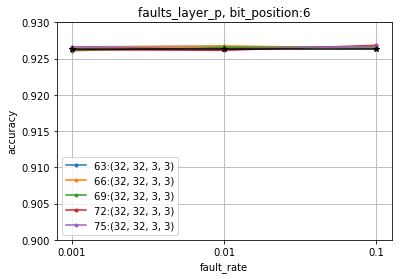

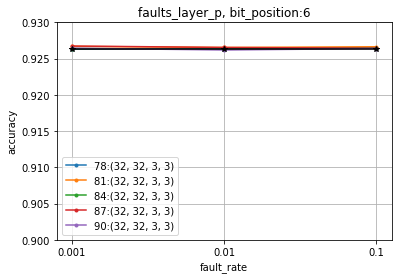

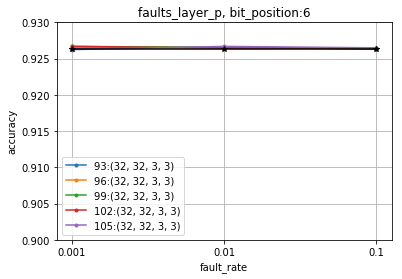

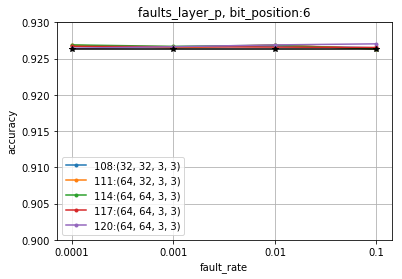

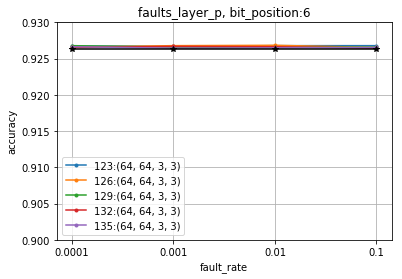

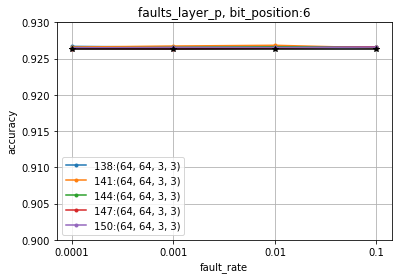

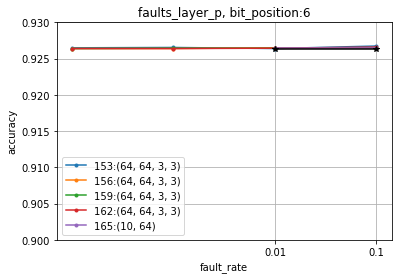

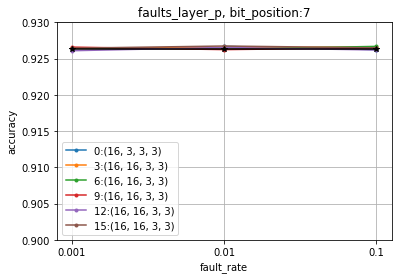

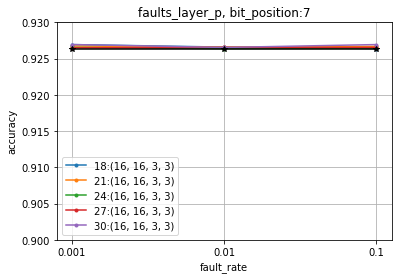

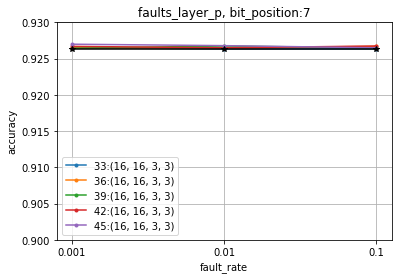

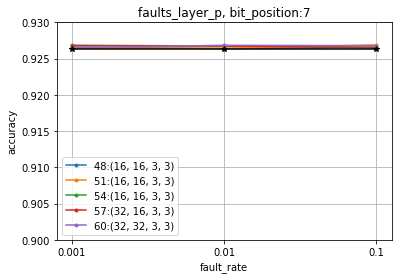

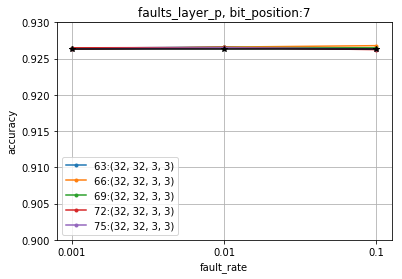

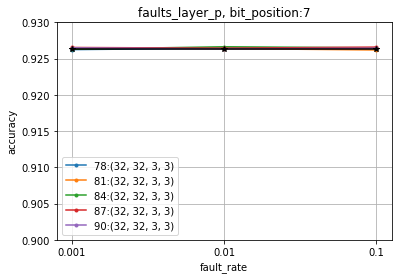

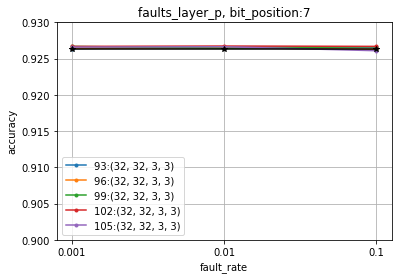

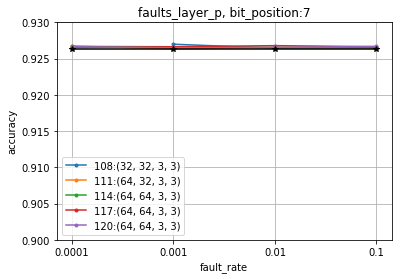

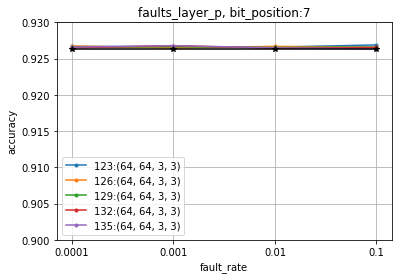

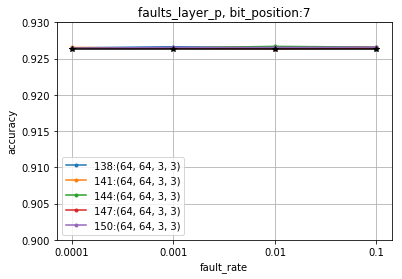

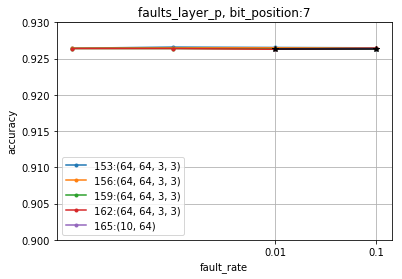

In [81]:
# x: fault_rate, y:accuracy; lengends: param_id 

for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 8):
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                if bit_position not in data[model_type][fault_type][param_id]:
                    break 
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
                num_values = res[fault_rates[0]][0, 0]
                x = np.log10(fault_rates)

                accuracies = [np.median(res[n_bits], axis=0)[2] for n_bits in fault_rates]
                plt.plot(x, accuracies, 
                         label='%d:%s' %(param_id, param_id_to_shape[param_id]), marker='.')
                
                if param_id in range(15, 166, 15):
                    plt.ylim(0.9, 0.93)
                    plt.legend()    
        #             plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
                    plt.grid()
                    plt.ylabel('accuracy')
                    plt.xlabel('fault_rate')
                    plt.title('%s, bit_position:%d' %(fault_type, bit_position))
                    plt.xticks(x, [s for i, s in enumerate(map(str, fault_rates))])
                    plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k')
                    plt.show()


0.1 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165]
0.1 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165]
0.1 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165]
0.1 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165]


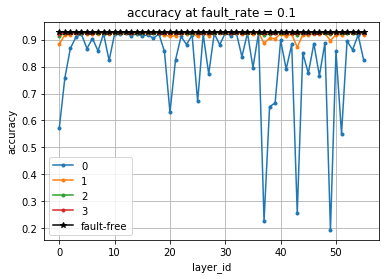

In [86]:
# group using the value at 0.01 
# x: fault_rate, y:accuracy; lengends: param_id 
def param_id_to_layer_id(param_id):
    assert param_id%3 == 0 
    return int(param_id/3)

for model_type in model_types:
    fault_free_accuracy = get_fault_free_accuracy(model_name, dataset_name, model_type)
    for fault_type in fault_types:
        
        for bit_position in range(0, 4):
            
#             accuracy_list = [] 
            anchors = [] # accuracy at fault_rate = 0.01
            param_ids = []
            anchor_fault_rate = 0.1
            
            for param_id in sorted(data[model_type][fault_type].keys()):
                if param_id not in weights_id:
                    continue 
                if bit_position not in data[model_type][fault_type][param_id]:
                    break 
                
                res = data[model_type][fault_type][param_id][bit_position]
                fault_rates = sorted(res.keys())
#                 num_values = res[fault_rates[0]][0, 0]
#                 x = np.log10(fault_rates)

#                 accuracies = [(fault_rate, np.min(res[fault_rate], axis=0)[2]) for fault_rate in fault_rates]
#                 accuracy_list.append(accuracies)
                if anchor_fault_rate in res:
                    anchors.append(np.median(res[anchor_fault_rate], axis=0)[2])
                    param_ids.append(param_id)
            
#             # group using anchors
#             tmp = sorted(zip(anchors, param_ids, accuracy_list), key=lambda x:x[0])
#             sorted_anchors, sorted_param_ids, sorted_accuracy_list = zip(*tmp)
            
            print(anchor_fault_rate, param_ids)
            x = [param_id_to_layer_id(x) for x in param_ids]
            plt.plot(x, anchors, label=str(bit_position), marker='.')
        plt.plot(x, [fault_free_accuracy]*len(x), marker='*', color='k', label='fault-free')
        plt.legend()
        plt.grid()
#         plt.ylim(0.8, 0.95)
        plt.xlabel('layer_id')
        plt.ylabel('accuracy')
        plt.title('accuracy at fault_rate = %s' %(anchor_fault_rate))


In [33]:
import pickle 
def load_pickle(load_path, load_name=None, verbose=False):
    if load_name:
        filepath =  os.path.join(load_path, load_name)
    else:
        filepath = load_path 
    if verbose:
        print('Load pickle file:', filepath)
    return pickle.load( open(filepath, "rb" ))

def parse_stats(stats):
    # input format:
    # stats = {param_name: {value: [(flipped bit position, bit value after flip, value after flip)]}}
    # output format: 
    # param_name: #values changed,  #0 -> 1 bit flips, # 1-> 0 bit flips 
    param_stats = {'changed_params':0, 
                               'flip_to_one': np.zeros(8), 
                               'flip_to_zero': np.zeros(8),
                              'value_before_flip': [],
                              'value_after_flip':[], 
                              'flipped_positions': []}
            
    for value_id, flip_list in stats.items():
        param_stats['changed_params'] += 1
        param_stats['value_before_flip'].append(flip_list[0][0])
        param_stats['value_after_flip'].append(flip_list[-1][-1])
        param_stats['flipped_positions'].append([x[1] for x in flip_list])

        for _, flip_pos, flip_bit, flip_value in flip_list:
            if flip_bit:
                param_stats['flip_to_one'][flip_pos] += 1
            else:
                param_stats['flip_to_zero'][flip_pos] += 1
    return param_stats 

def trial_id_to_stats_files(trial_id):
    return str(trial_id)+'.pkl' 

def load_and_average_stats(results_dir, trial_ids):
    stat_dir = os.path.join(results_dir, 'stats')
    stats_files = map(trial_id_to_stats_files, trial_ids)
    avg_param_stats = None 
    for f in stats_files:
        # each trial is saved as a pickle 
        stats = load_pickle(stat_dir, f, verbose=False)
#         print(stats)
         
        param_stats = parse_stats(stats)
        if avg_param_stats:
            for key, value in param_stats.items():
                avg_param_stats[key] += value 
        else:
            avg_param_stats = param_stats
    return avg_param_stats
                    

fault_rate: 0.010000, #values: 432
accuracies: [0.9218 0.923  0.9206]
flip_to_one: 6, flip_to_zero: 6
[(-17, -81), (27, 91), (0, 64), (-29, -93), (-21, -85), (-9, -73), (-13, -77), (10, 74), (11, 75), (0, 64)]


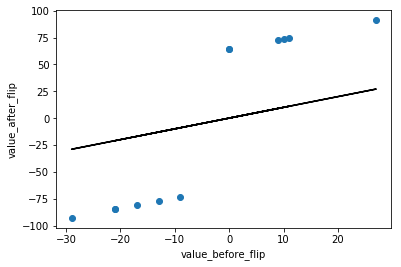

In [38]:

model_type = 'full'
fault_type = fault_types[0]
param_id = 0
bit_position = 1
n_bits = 0.01

print('fault_rate: %f, #values: %d' %(n_bits, data[model_type][fault_type][param_id][bit_position][n_bits][0,0]))
print('accuracies:', data[model_type][fault_type][param_id][bit_position][n_bits][:, 2])

folder = 'param-%d/bit-%d/r-%s' %(param_id, bit_position, n_bits)
results_dir = os.path.join(get_results_dir(model_name, dataset_name, model_type, fault_type), folder)

avg_params_stats = load_and_average_stats(results_dir, range(3)) 
# print(avg_params_stats)
# plt.bar(range(32), avg_params_stats['flip_to_one'])
# plt.title('flip to one')
# plt.show()

# plt.bar(range(32), avg_params_stats['flip_to_zero'])
# plt.title('flip to zero')
# plt.show() 
print('flip_to_one: %d, flip_to_zero: %d' 
      %(avg_params_stats['flip_to_one'][bit_position], avg_params_stats['flip_to_zero'][bit_position]))

print(list(zip(avg_params_stats['value_before_flip'][:10], avg_params_stats['value_after_flip'][:10])))
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_after_flip'], 'o')
plt.xlabel('value_before_flip')
plt.ylabel('value_after_flip')
plt.plot(avg_params_stats['value_before_flip'], avg_params_stats['value_before_flip'], 'k-')
plt.show()

prec1: 0.9375


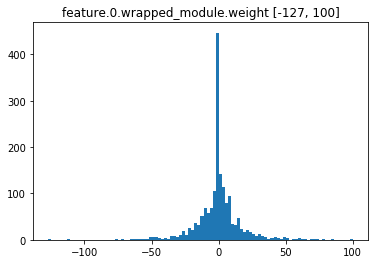

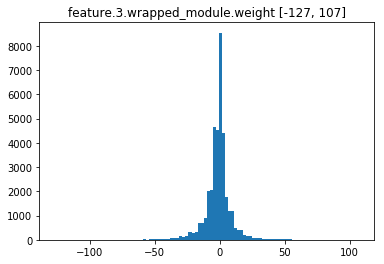

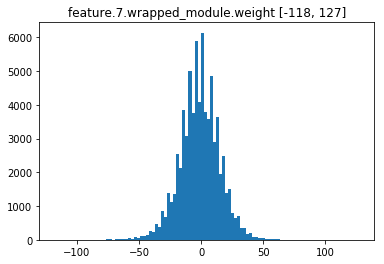

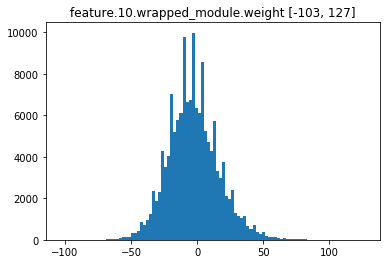

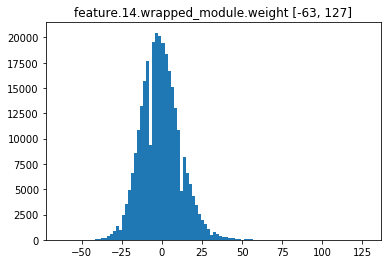

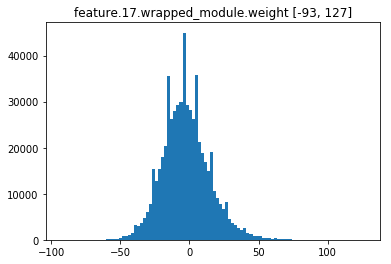

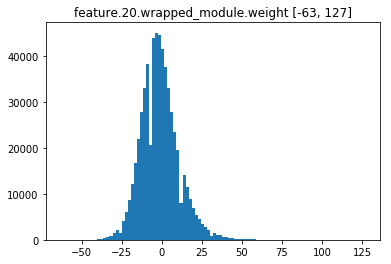

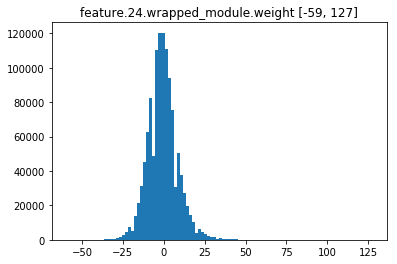

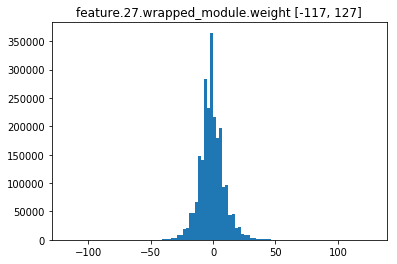

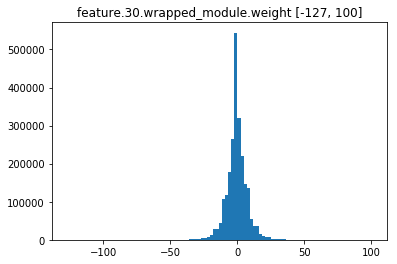

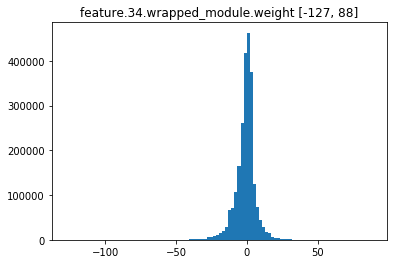

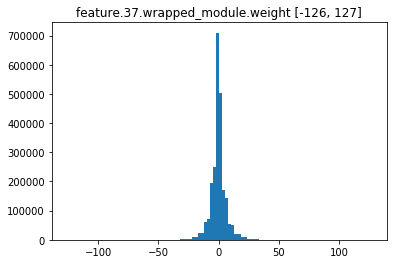

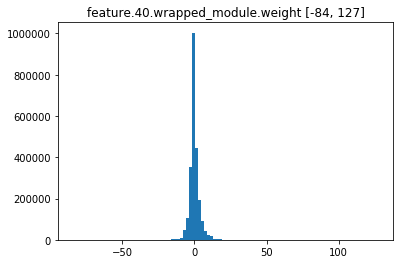

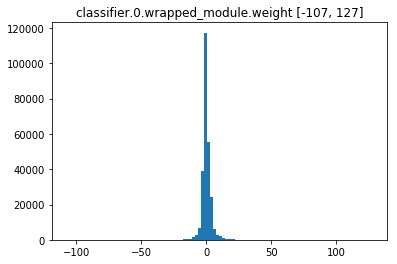

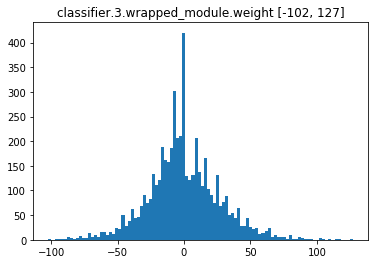

In [12]:
# import torch 

# model_path = './logs/vgg16/cifar10/int8/quantized.pth.tar'
# checkpoint = torch.load(model_path)
# prec1 = checkpoint['prec1']
# print('prec1:', prec1)
# state_dict = checkpoint['state_dict']
# for key in state_dict:
#     tensor = state_dict[key]
#     if len(tensor.size()) < 2:
#         continue
#     minv, maxv = tensor.min().item(), tensor.max().item() 
#     plt.hist(tensor.cpu().numpy().ravel(), bins=100)
#     plt.title(key+' [%d, %d]' %(minv, maxv))
#     plt.show()